# Forecasting Electricity Consumption

Forecasting the electricity usage in the future is a core part of any electricity retailer's business, this helps them estimate how much electricity they may need to buy off the grid in advance. If the load(The retailer's customers electricity usage) is known in advance, the electricity retailers can hedge against the price to ensure they are not caught off guard when the price sky rockets three months into the future. 

The Business problem here therefore is:
**Given the historical power consumption, what is the expected power consumption for the next year?**

Because we are predicting the  daily load for the next 365 days, there are multiple 'time steps' and this form of forecasting is known as multi-step forecasting. In contrast, if we were predictiong the consumption on the 365th day only, this would require a 'one-step forecast'.

The dataset is from: https://www.kaggle.com/robikscube/hourly-energy-consumption
PJM Interconnection LLC (PJM) is a regional transmission organization (RTO) in the United States. It is part of the Eastern Interconnection grid operating an electric transmission system serving all or parts of Delaware, Illinois, Indiana, Kentucky, Maryland, Michigan, New Jersey, North Carolina, Ohio, Pennsylvania, Tennessee, Virginia, West Virginia, and the District of Columbia.

This data comes from PJM's website and are in Megawatts(MW). The regions have changed over time, therefore data may only appear for certain dates

PJM is one of the world's largest wholesale electricity markets, encompassing over 1,000 companies, 65 million customers and delivered 807 terawatt-hours of electricity in 2018 - see their annual report.

We'll use the PJM East Region dataset - which covers the eastern states of the PJM area.

Forecasting time series data is different to other forms of machine learning problems due to the fact that time series data is often correlated with the past. Therefore, to make the model factor this in 'shifting' feature engineering techniques can be used. 

This notebook will attemot to forecast energy conumption to give an idea of how time series forecasting works. We'll use.
1. Holtwinters Triple Exponential Smoothing.
2. Seasonal Autoregression Intergrated Moving Average(SARIMA)
3. XGBoost Regressor
4. LASSO Regularised Regression
5. Facebook's Prophet


In [15]:
#importing the necessary dependencies
import numpy as np
import pandas as pd
from datetime import datetime

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import xgboost as xgb
from xgboost import plot_importance,plot_tree
from sklearn.metrics import mean_squared_error,mean_absolute_error

plt.style.use('fivethirtyeight')
from pylab import rcParams
rcParams['figure.figsize'] = 11, 9 #Changes default matplotlib plots to this size

## Data Preparation & Cleaning

We will be using the hourly power consumption data from PJM. 

In [2]:
#importing the dataset-making the first column to to be the index column.
#parse_dates-converts the column values to datetime datatype
dataset = pd.read_csv('Data/PJME_hourly.csv',index_col = [0],parse_dates=[0])
dataset.head()

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0


In [3]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 145366 entries, 2002-12-31 01:00:00 to 2018-01-02 00:00:00
Data columns (total 1 columns):
PJME_MW    145366 non-null float64
dtypes: float64(1)
memory usage: 2.2 MB


In [4]:
#checking for null values
dataset.isna().sum()

PJME_MW    0
dtype: int64

In [5]:
#checking for duplicates in the dataset
#dataset.loc[dataset.duplicated()]

In [6]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 145366 entries, 2002-12-31 01:00:00 to 2018-01-02 00:00:00
Data columns (total 1 columns):
PJME_MW    145366 non-null float64
dtypes: float64(1)
memory usage: 2.2 MB


In [7]:
#plotting the dataset by hour
df = dataset.groupby(dataset.index).first()

#setting the frequency to Hour
df = df.asfreq('H')
df.head()

,PJME_MW
Datetime,
2002-01-01 01:00:00,30393.0
2002-01-01 02:00:00,29265.0
2002-01-01 03:00:00,28357.0
2002-01-01 04:00:00,27899.0
2002-01-01 05:00:00,28057.0


After preprocessing and cleaning the data, the next step is to plot the data with the frequency at the hourly level. 

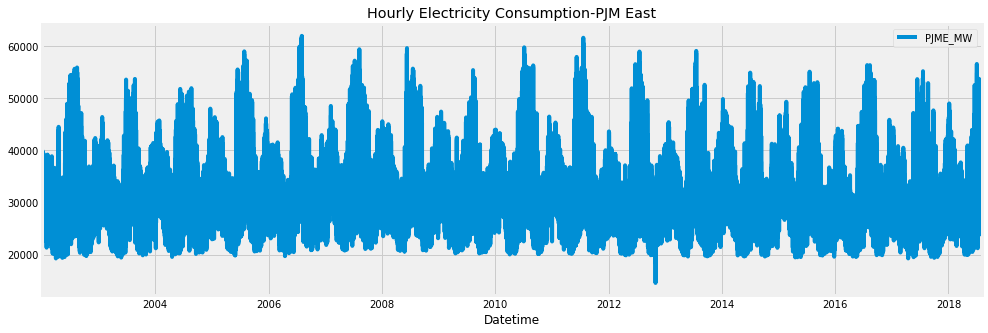

In [8]:
#visualizing the data
df.plot(figsize = (15,5),title='Hourly Electricity Consumption-PJM East',)

plt.show()


We can see because the frequency is at the hourly level, this will make forecasting difficult, more so, it is also difficult to visualize too.

To get a clear visualization , we'll have to resample the dataframe and aggregate it to a daily level.

In [9]:
#resampling the data at daily level
daily_data = dataset.resample(rule = 'D').sum()

#setting the frequency
daily_data = daily_data.asfreq('D')

daily_data.head()

,PJME_MW
Datetime,
2002-01-01,714857.0
2002-01-02,822277.0
2002-01-03,828285.0
2002-01-04,809171.0
2002-01-05,729723.0


In [10]:
#confirming that the data is at the right frequency.
daily_data.index

DatetimeIndex(['2002-01-01', '2002-01-02', '2002-01-03', '2002-01-04',
               '2002-01-05', '2002-01-06', '2002-01-07', '2002-01-08',
               '2002-01-09', '2002-01-10',
               ...
               '2018-07-25', '2018-07-26', '2018-07-27', '2018-07-28',
               '2018-07-29', '2018-07-30', '2018-07-31', '2018-08-01',
               '2018-08-02', '2018-08-03'],
              dtype='datetime64[ns]', name='Datetime', length=6059, freq='D')

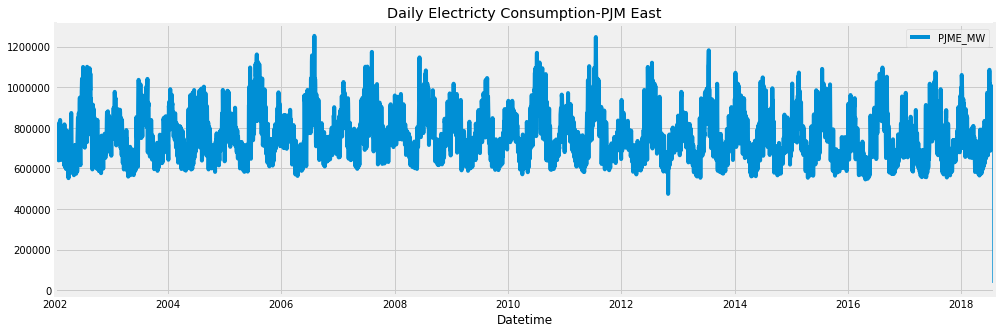

In [11]:
#visualizing the data- daily basis
daily_data.plot(figsize = (15,5),title='Daily Electricty Consumption-PJM East')
plt.show()

In [12]:
#checking why there is a drop at the tail end?
df.tail()

,PJME_MW
Datetime,
2018-08-02 20:00:00,44057.0
2018-08-02 21:00:00,43256.0
2018-08-02 22:00:00,41552.0
2018-08-02 23:00:00,38500.0
2018-08-03 00:00:00,35486.0


There's a drop at the tail, end because we do not have the data for the full day. For this analysis, we will need to delete that part- 3rd August.

In [13]:
#dropping off values
daily_data = daily_data.drop([daily_data.index.min(),daily_data.index.max()])


**Seasonal Decomposition**

At a high-level, time series data can be thought of as:
1. Level: The average value in the series.
2. Trend: The increasing or decreasing value in the series.
3. Seasonality: The repeating short-term cycle in the series.
4. Noise/Residual: The random variation in the series.

We can use the statsmodel library to 'decompose' the above components.

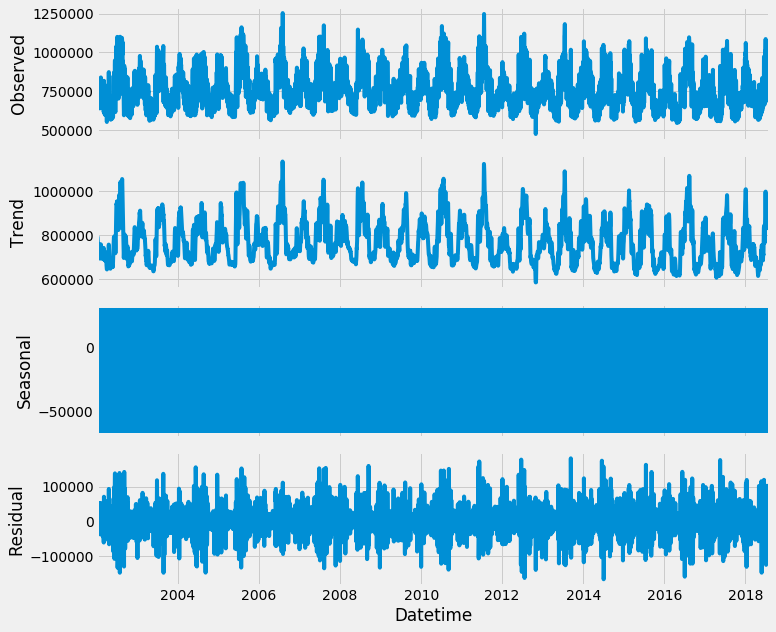

In [16]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(daily_data, model = 'additive')

#visualization
fig = decomposition.plot()

plt.show()

It is quite difficult to see what's going on in the above plots as the graph is 'packed together'. More traditional econometric/statistical models such as Holtwinters and SARIMA, require three characteristics for them to work properly, namely:
1. Seasonality: The dataset is cyclical in nature.
2. Stationarity: The properties of the dataset don't change over time.
3. Autocorelation: there is a similarity between current and past(i.e lagged data points)

To reduce the noise in the data, we can aggregate the data weekly.

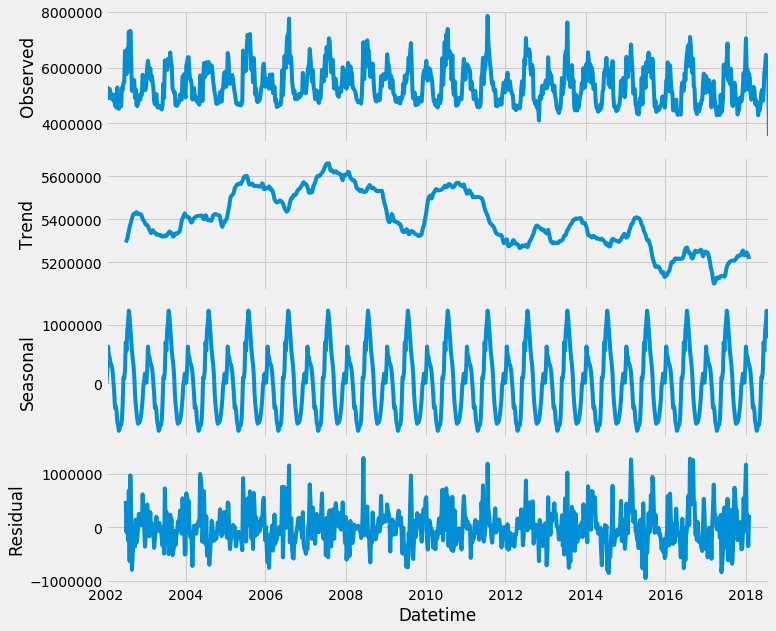

In [17]:
# grouping the data weekly
weekly_data = dataset.resample(rule = 'W').sum()

decomposition = seasonal_decompose(weekly_data,model='additive')

fig = decomposition.plot()
plt.show()

We can start seeing a pattern/trend emerge- Electricity usage peak and troughs seem to be very seasonal and repetitive. The trend of the data-the electricity usage seems to ve trailing downwards in the last few years.

Another way to visualize the data is to use a heatmap - This can be analyzed weekly to see which days have the higher electricity usgae. We will have to drop 2018, as it is not a full year and will skew the observation.

In [18]:
# creating a heatmap
heatmap_data = daily_data.copy()

#adding weekdays column
heatmap_data['Weekday_Name'] = heatmap_data.index.weekday_name

#adding the Year column
heatmap_data['Year'] = heatmap_data.index.year
heatmap_data = heatmap_data.groupby(['Year','Weekday_Name']).sum().reset_index()

#dropping off 2018 as it is not a complete year
heatmap_data = heatmap_data[heatmap_data['Year'] != 2018]

#Pivoting the table
heatmap_data = heatmap_data.pivot(index = 'Year',columns = 'Weekday_Name',values = 'PJME_MW')

#re-ordering the columns
heatmap_data = heatmap_data[['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']]

heatmap_data.head()

Weekday_Name,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
Year,,,,,,,
2002,40559596.0,41562544.0,41502149.0,40797927.0,39906312.0,36214879.0,35161845.0
2003,40418610.0,40978444.0,41535338.0,40835617.0,40674536.0,37247732.0,35927451.0
2004,41011526.0,42102790.0,42042876.0,42615827.0,42037861.0,37627342.0,35960737.0
2005,42042356.0,43071343.0,43424862.0,43016356.0,42521582.0,39916126.0,37740547.0
2006,41391013.0,42255918.0,42123538.0,41725185.0,40968212.0,37624531.0,37751987.0


Text(0.5, 1, 'Heatmap_by Day of Week')

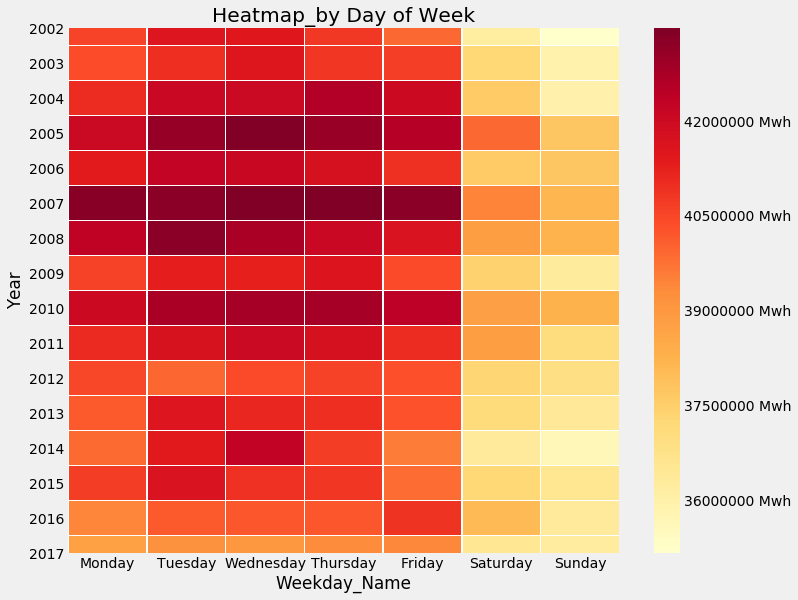

In [19]:
# visualizing the heatmap
sns.heatmap(heatmap_data,linewidths=.5,cmap = 'YlOrRd',cbar = True,
            cbar_kws = {"format": '%1.0f Mwh'}).set_title('Heatmap_by Day of Week')

The weekends have lower electricity usage probably due to the fact that many businesses are closed during the weekends. It also seems 2007. had quite a high usage across all the weekdays.

We can also visualize the heatmap for electricity usage by hour.

In [20]:
# creating a heatmap
heatmap_data = dataset.copy()

#adding Hours column
heatmap_data['Hour'] = heatmap_data.index.hour

#adding the Year column
heatmap_data['Year'] = heatmap_data.index.year
heatmap_data = heatmap_data.groupby(['Year','Hour']).sum().reset_index()

#dropping off 2018 as it is not a complete year
heatmap_data = heatmap_data[heatmap_data['Year'] != 2018]

#Pivoting the table
heatmap_data = heatmap_data.pivot(index = 'Year',columns = 'Hour',values = 'PJME_MW')

heatmap_data.head()

Hour,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
Year,,,,,,,,,,,,,,,,,,,,,
2002,10555395.0,9815263.0,9335986.0,9085390.0,8996000.0,9088508.0,9561362.0,10478310.0,11256367.0,11754869.0,...,12659081.0,12635909.0,12644627.0,12801822.0,13099769.0,13118837.0,12973435.0,12845175.0,12421482.0,11546851.0
2003,10628849.0,9876055.0,9416911.0,9185955.0,9114624.0,9218899.0,9731298.0,10665568.0,11425318.0,11897609.0,...,12626754.0,12584423.0,12570529.0,12722624.0,13024083.0,13067172.0,12972139.0,12872530.0,12455050.0,11588825.0
2004,10853980.0,10082380.0,9611380.0,9361850.0,9284763.0,9393423.0,9913531.0,10850183.0,11608294.0,12079820.0,...,12904112.0,12878572.0,12890501.0,13059614.0,13364466.0,13403130.0,13284203.0,13169499.0,12732275.0,11830098.0
2005,11165424.0,10392273.0,9908003.0,9655564.0,9575405.0,9685438.0,10208623.0,11136212.0,11878090.0,12359541.0,...,13304389.0,13296409.0,13322850.0,13499920.0,13806159.0,13817318.0,13684655.0,13568005.0,13099973.0,12165342.0
2006,10853993.0,10093946.0,9614511.0,9366089.0,9283392.0,9400221.0,9935520.0,10868819.0,11600873.0,12055666.0,...,12938660.0,12918631.0,12928152.0,13094555.0,13411002.0,13450723.0,13348270.0,13233525.0,12762157.0,11835063.0


Text(0.5, 1, 'Heatmap_by Hour of Day')

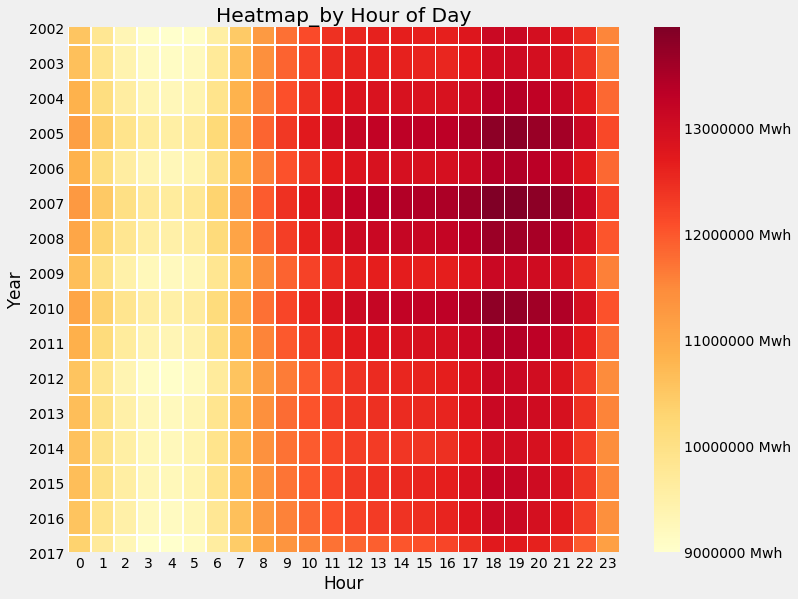

In [21]:
# visualizing the heatmap
sns.heatmap(heatmap_data,linewidths=.5,cmap = 'YlOrRd',cbar = True,
            cbar_kws = {"format": '%1.0f Mwh'}).set_title('Heatmap_by Hour of Day')

It is interesting to note from the above visualization, that the peak usage is between 11am to 9pm.

Next, we can compare the electricity usage during the months of the year.

In [22]:
# creating a heatmap
heatmap_data = dataset.copy()

#adding Hours column
heatmap_data['Month'] = heatmap_data.index.month_name()

#adding the Year column
heatmap_data['Year'] = heatmap_data.index.year
heatmap_data = heatmap_data.groupby(['Year','Month']).sum().reset_index()

#dropping off 2018 as it is not a complete year
heatmap_data = heatmap_data[heatmap_data['Year'] != 2018]

#Pivoting the table
heatmap_data = heatmap_data.pivot(index = 'Year',columns = 'Month',values = 'PJME_MW')

# Reorder columns
heatmap_data = heatmap_data[['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 
                             'October', 'November', 'December']]
heatmap_data.head()

Month,January,February,March,April,May,June,July,August,September,October,November,December
Year,,,,,,,,,,,,
2002,23089022.0,20320720.0,21483191.0,20516472.0,20886798.0,24181862.0,28303171.0,28282432.0,22522657.0,21425753.0,21181133.0,24226898.0
2003,26029003.0,22876353.0,22463917.0,20361487.0,20229013.0,22763740.0,27096616.0,27666731.0,22010477.0,20871168.0,20817246.0,24431977.0
2004,26849900.0,23182028.0,22525939.0,20607391.0,23401869.0,23978879.0,26753607.0,26545361.0,22883683.0,20931584.0,21127232.0,24611486.0
2005,25835806.0,22366527.0,23811599.0,20238773.0,20595988.0,26046220.0,29282426.0,29802886.0,24685915.0,21794083.0,21558593.0,25714356.0
2006,24270315.0,22521844.0,23141132.0,19923539.0,21583435.0,24783648.0,29831183.0,28960439.0,21789803.0,21748478.0,21532040.0,23754528.0


Text(0.5, 1, 'Heatmap_by Month of Year')

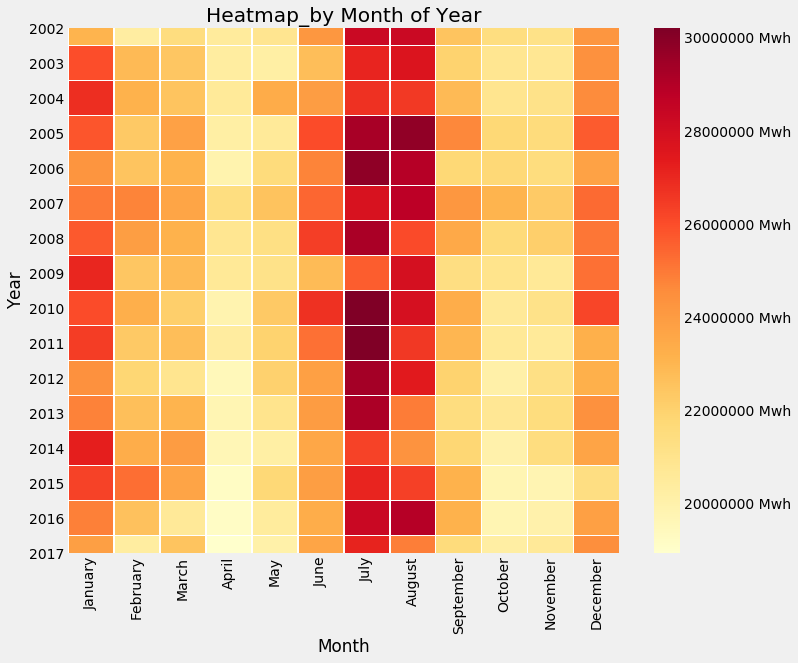

In [23]:
# visualizing the heatmap
sns.heatmap(heatmap_data,linewidths=.5,cmap = 'YlOrRd',cbar = True,
            cbar_kws = {"format": '%1.0f Mwh'}).set_title('Heatmap_by Month of Year')

The above plot shows, July has the heaviest usage, which is expected as it is the peak of the summer. A lot of the power is used in cooling- Air conditioners. There is also increased elctricity usage in the months of December and January probably due to the winter weather. 

To get a better look at the data,we can add weather data. As this analysis focusses on PJM East Region, for simplicity we can use Washington's D.C's weather data as a reference point.

In [24]:
#loading the weather dataset
weather_data_2017 = pd.read_csv('Data/Washington_DC_Weather_Avg_Temp_2016-17.csv')

weather_data_2018 = pd.read_csv('Data/Washington_DC_Weather_Avg_Temp_2018.csv')

#merging the two dataframes
weather_data = pd.concat([weather_data_2017,weather_data_2018])

weather_data.head(10)

,STATION,NAME,DATE,TAVG
0,US1MDMG0109,"SILVER SPRING 2.1 NNE, MD US",2016-03-31,NaN
1,US1MDMG0109,"SILVER SPRING 2.1 NNE, MD US",2016-04-01,NaN
2,US1MDMG0109,"SILVER SPRING 2.1 NNE, MD US",2016-04-02,NaN
3,US1MDMG0109,"SILVER SPRING 2.1 NNE, MD US",2016-04-03,NaN
4,US1MDMG0109,"SILVER SPRING 2.1 NNE, MD US",2016-04-04,NaN
5,US1MDMG0109,"SILVER SPRING 2.1 NNE, MD US",2016-04-05,NaN
6,US1MDMG0109,"SILVER SPRING 2.1 NNE, MD US",2016-04-06,NaN
7,US1MDMG0109,"SILVER SPRING 2.1 NNE, MD US",2016-04-07,NaN
8,US1MDMG0109,"SILVER SPRING 2.1 NNE, MD US",2016-04-08,NaN
9,US1MDMG0109,"SILVER SPRING 2.1 NNE, MD US",2016-04-09,NaN


In [25]:
#getting more information on the weather dataframe
weather_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 102831 entries, 0 to 35699
Data columns (total 4 columns):
STATION    102831 non-null object
NAME       102831 non-null object
DATE       102831 non-null object
TAVG       3104 non-null float64
dtypes: float64(1), object(3)
memory usage: 3.9+ MB


In [26]:
# the data requires further cleaning
weather_data = weather_data[['DATE','TAVG']]

#using Non-Null TAVG values
weather_data = weather_data[~weather_data['TAVG'].isna()].reset_index()

#grouping the data by date
weather_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3104 entries, 0 to 3103
Data columns (total 3 columns):
index    3104 non-null int64
DATE     3104 non-null object
TAVG     3104 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 72.9+ KB


In [27]:
# cleaning of the data_selcting only the necessary columns
weather_data = weather_data[['DATE','TAVG']]

#excluding the null values from the dataFrame
weather_data = weather_data[~weather_data['TAVG'].isna()]

#grouping by date
weather_data.groupby(['DATE']).mean()
weather_data = weather_data.set_index('DATE')
weather_data.index = pd.to_datetime(weather_data.index)

#sorting the values

weather_data = weather_data.sort_values(by = 'DATE',ascending = True)


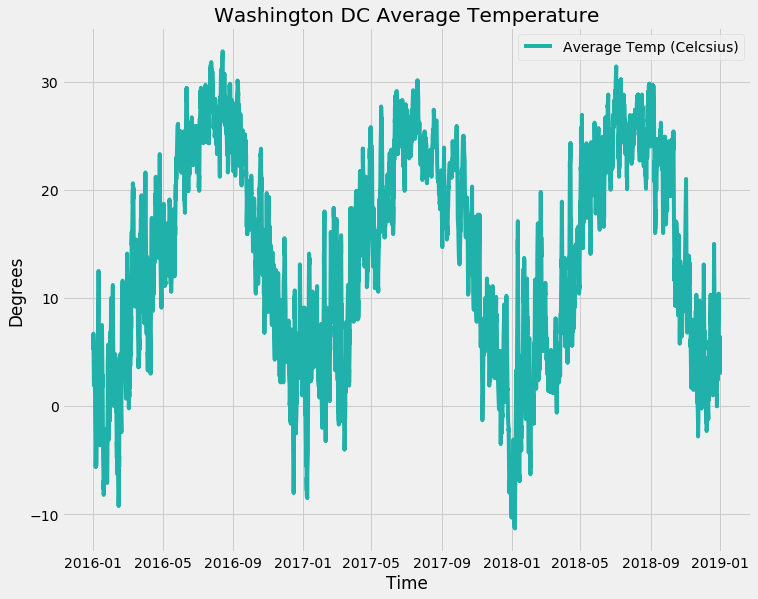

In [28]:
#plotting
plt.plot(weather_data, label = 'Average Temp (Celcsius)',color = 'lightseagreen')

plt.title('Washington DC Average Temperature')
plt.legend(loc = 'best')
plt.xlabel('Time')
plt.ylabel('Degrees')

plt.show()

We now need to visualize both the average temp variation and the electrcity usage side by side

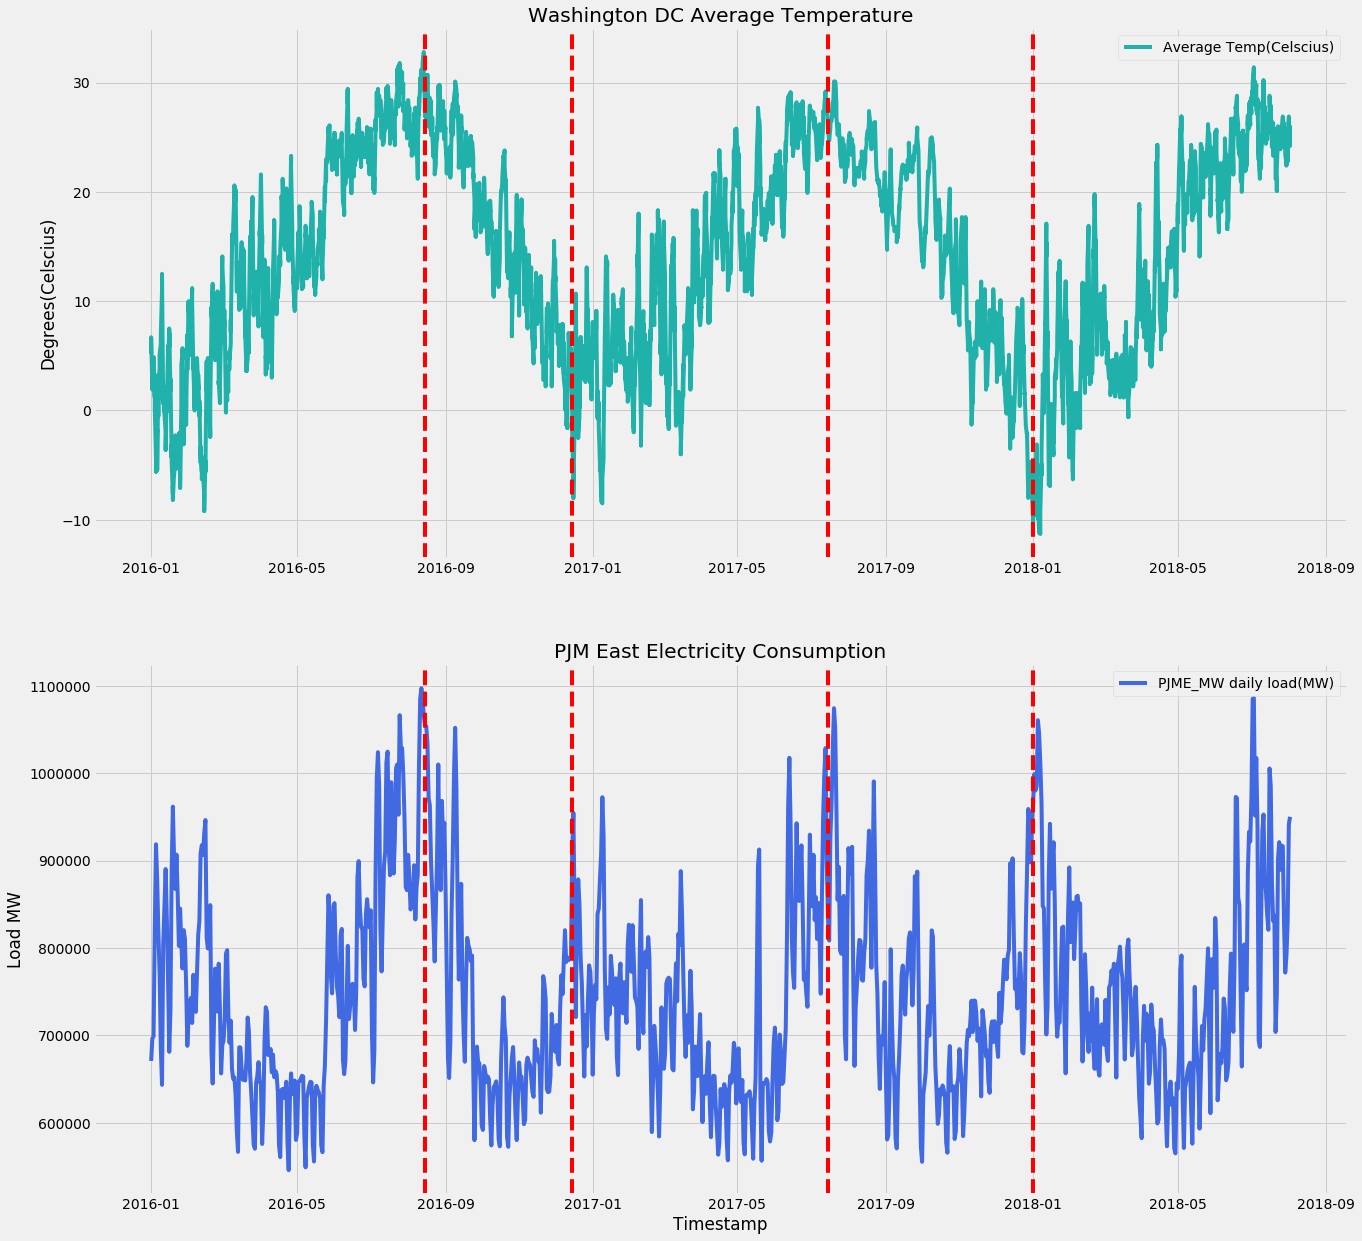

In [29]:
fig, ax = plt.subplots(2,1,figsize=(20,20))

# Temperature plot
ax[0].plot(weather_data['2016-01-01':"2018-08-02"],label = 'Average Temp(Celscius)',color ='lightseagreen')
ax[0].set_title('Washington DC Average Temperature')
ax[0].set_ylabel('Degrees(Celscius)')
ax[0].legend(loc = 'best')

#plot 2
ax[1].plot(daily_data['2016-01-01':"2018-08-02"],label = 'PJME_MW daily load(MW)',
          color = 'royalblue')
ax[1].set_title('PJM East Electricity Consumption')
ax[1].set_xlabel('Timestamp')
ax[1].set_ylabel('Load MW')
ax[1].legend(loc = 'best')

#adding vertical lines
import datetime as dt
ax[0].axvline(dt.datetime(2016, 8, 15), color='red', linestyle='--')
ax[1].axvline(dt.datetime(2016, 8, 15), color='red', linestyle='--')
ax[0].axvline(dt.datetime(2016, 12, 15), color='red', linestyle='--')
ax[1].axvline(dt.datetime(2016, 12, 15), color='red', linestyle='--')
ax[0].axvline(dt.datetime(2017, 7, 15), color='red', linestyle='--')
ax[1].axvline(dt.datetime(2017, 7, 15), color='red', linestyle='--')
ax[0].axvline(dt.datetime(2018, 1, 1), color='red', linestyle='--')
ax[1].axvline(dt.datetime(2018, 1, 1), color='red', linestyle='--')
plt.show()

In [30]:
#checking the corelation between the two
correlation = daily_data['2016-01-01':'2018-08-02']['PJME_MW'].corr(weather_data['2016-01-01':'2018-08-02']['TAVG'], 
                                                                    method='pearson')

print("The correlation between the PJM East Region electricity load and Washington D.C. average temperature is: {}%".format(correlation*100))

The correlation between the PJM East Region electricity load and Washington D.C. average temperature is: 13.031370620708008%


It is interesting to note that the correlation between the electricity consumption in the PJM East Regiom and the average Temperature in Washington DC is 13.03%. This means, extreme peaks inweather causes spikes , but weather generally isn't useful for predicting electricity usage.

**Statistical Text "Smoke Alarms"**

There are certain good statistical tests one can apply to a dataset as a 'smoke alarm' test. They are a good indication whether data is conducive for accurate forecasting.

1. **Stationary:** This means the properties of the dataset do not change overtime. Non-stationary means the trends, seasonality changes over time and the data is affected by factors other than passage of time. A Non-Stationary is sometimes known as a 'Random Walk' - which are notoriously difficult to forecast, because the underlying properties keep changing (e.g. like trying to hit a moving target).

In [87]:
from statsmodels.tsa.stattools import adfuller as ADF

series = daily_data['PJME_MW']  #ADF takes a series not a dataFrame

result = ADF(series)

print('ADF Statistic :',result[0])
print('P-value: {:.20f}'.format(result[1]))

ADF Statistic : -8.235350407910804
P-value: 0.00000000000059105282


2. **Homoscedacity:** refers to instances where the data is evenly distributed along a regression line. Basically it means the data is more closely grouped together and therefore is less 'spiky'. Heteroscedactic data means the peaks and troughs (ie outliers) are being observed way more often than a 'normally distributed' dataset. This means that a model will have a hard time predicting these spikes. To alleviate this, heteroskedactic data generally needs to be Box-Cox/log transformed to dampen the extreme peaks/troughs. That is, bringing the data closer together so a model can better fit the whole data and hit the peaks/troughs. simply put: homoscdacity means 'having the same scatter' while heteroscedacity means 'having different scatter, where points are at a widely varying distance from the regression line. 



In [89]:
# runing test for heteroskedacity
from statsmodels.stats.diagnostic import het_breuschpagan as BP
import statsmodels.api as sm
from statsmodels.formula.api import ols

bp_data = daily_data.copy()

# Convert time series points into consecutive ints
bp_data['Time_Period'] = range(1, len(bp_data)+1)

# ie PJME MW depends on Time Period (OLS auto adds Y intercept)
formula = 'PJME_MW ~ Time_Period'

# Next we apply Ordinary Linear Square baseline regression model - as baseline test
model = ols(formula, bp_data).fit()

result = BP(model.resid, model.model.exog)

print('ADF Statistic: ', result[0])
print('P-value: {:.20f}'.format(result[1]))

ADF Statistic:  1.2875922619407587
P-value: 0.25649214066307707283


From the above 'smoke alarm' tests, we can conclude that:
1. The data is stationary(as the P-value was below 0.05).
2. The data is heteroscedastic(as the P-value was above 0.05)

This also explains why the seasonal decomposition has a lot of noise and crazy swings.The consequences of these statistical tests means that the traditional assumptions of linear regression have been violated. That is, more conventional methods of linear regression, statistical F-Tests and T-Tests become ineffective.

Therefore, this forecasting model won't factor in these tests.

**Autocorrelation**

Autocorrelation is basically how much correlation there is between a particular time point and a prior one - e.g. today's value is highly correleated with last week's value.

Python Statsmodel has a great Autocorrelation Function (ACF) that easily produces this:


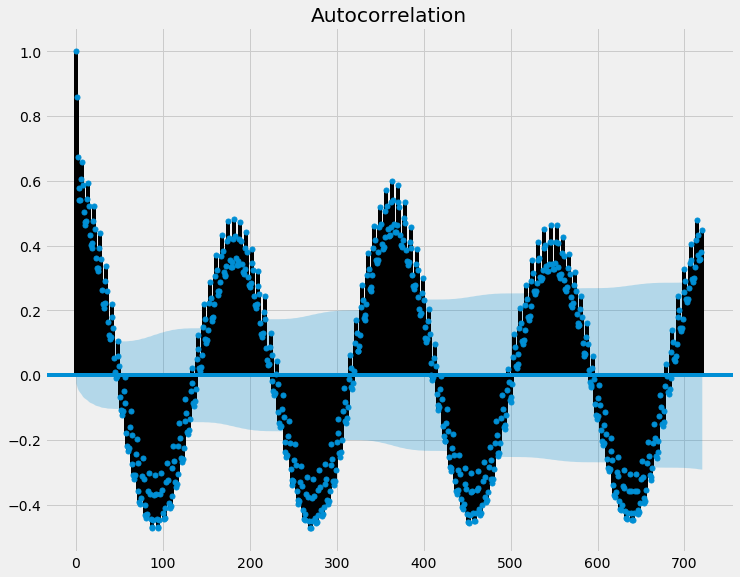

In [90]:
#importing the necessary dependencies
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf

# Plot the acf function
plot_acf(daily_data['PJME_MW'],lags=720) #alpha 1 suppresses CI

plt.show()

What the above graph shows is how correlated a prior point is to the current point. The further the number is away from 0, the more correlation there is.

Generally, we would only consider any points above (for positive numbers) and below (for negative numbers) the blue shaded area (the confidence interval) as statistically significant and worth noting.

This shows that yesterday's value has a very high correlation with today's value and there is seasonality - every 6 months it seems to repeat itself.

As eluded earlier, this makes sense if you factor in weather patterns - winter and summer have higher electricity usage due to more heat/cooling needed.

Thus is probably because of the weather - winter and summer have higher electricity usage.

Another modification of this autocorrelation analysis is the Partial Autocorrelation Function (PACF). This function is a variant of ACF, as it finds correlation of the residuals, after removing the effects which are already explained in earlier lags. That way, you don't get a 'compounding' correlation effect.



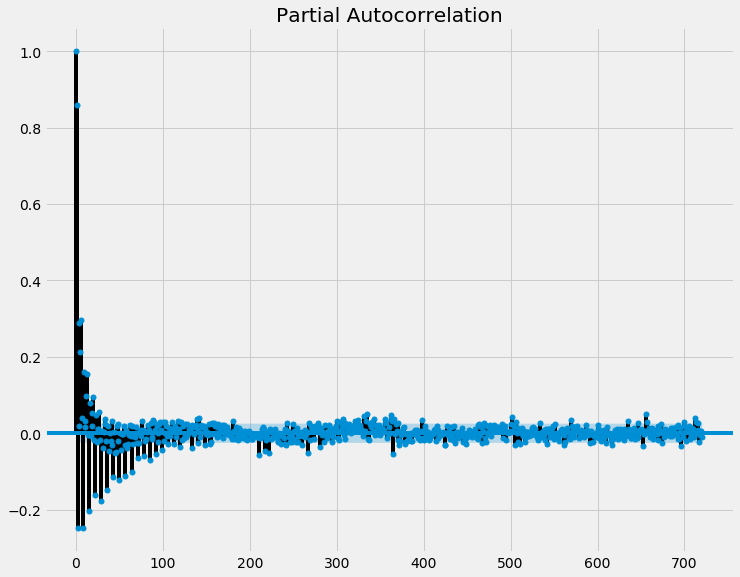

In [92]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(daily_data['PJME_MW'],lags=720) #alpha 1 suppress CI

plt.show()

This graph shows that the last 90 days have a stronger correlation, but the effect becomes much less obvious the further back you go

# Prediction Modelling

**Splitting the Dataset**

In [31]:
# First we split it up between train and test
# We will aim for a 12 month forecast horizon (ie predict the last 12 months in the dataset)
cutoff = '2017-08-03'

daily_data.sort_index()

train = daily_data[:cutoff]
test = daily_data[cutoff:]

## **Baseline Model - Naive Forecasting.**

Before we go knee-deep into machine learning, it is good to use naive forecasting techniques to determine a 'baseline'. That is, if the ML models cannot beat these baseline forecasts, then we would be better off just using naive forecast instead.

They are 'naive' in the sense they are simple to apply, but in reality they are pretty powerful and effective forecasts. Not too many ML models actually can consistently beat a naive forecast!

A common naive forecast for predicting a multi-step forecast (i.e. for us, it would be the next 365 days), is to use a 'One-Year-Ago Persistent Forecast'. This basically means the value for say 31 August 2019 is predicted using the value for 31 August 2018.

In [32]:
baseline_prediction = train['2016-08-03':'2017-08-02']

baseline_prediction.index = pd.date_range(start='2017-08-03', end='2018-08-02', freq='D')

baseline_prediction.tail()

,PJME_MW
2018-07-29,700426.0
2018-07-30,672616.0
2018-07-31,830714.0
2018-08-01,914385.0
2018-08-02,895428.0


Let's evaluate our model using Mean Absolute Error (MAE) and visualise the results.

Mean Absolute Error (MAE) is an evaluation metric that measures the average magnitude of the errors in a set of predictions. In other words how 'wrong' the model is. Unlike other metrics, such as Root Mean Squared Error, it does not have any particular weighting.

In [96]:
#Evaluate it's performance using Mean Absolute Error (MAE)
from statsmodels.tools.eval_measures import meanabs

print("MAE Baseline: {:.20f}".format(meanabs(test['PJME_MW'], 
                                             baseline_prediction['PJME_MW'])))

MAE Baseline: 87377.28219178081781137735


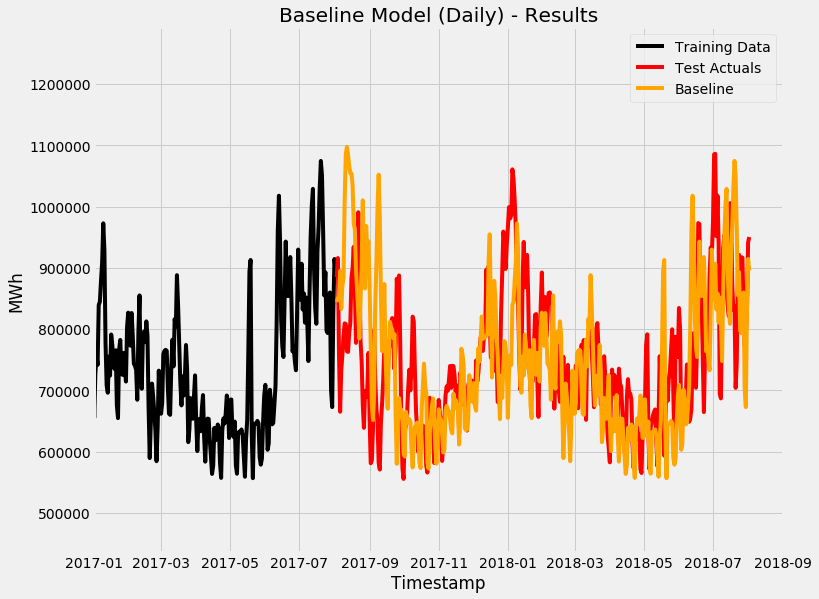

In [33]:
# Let's visually see the results
plt.plot(train, label='Training Data', color='black')
plt.plot(test, label='Test Actuals', color='red')
plt.plot(baseline_prediction, label='Baseline', color='orange')

# Plot Labels, Legends etc
plt.xlabel("Timestamp")
plt.ylabel("MWh")
plt.legend(loc='best')
plt.title('Baseline Model (Daily) - Results')

# For clarify, let's limit to only 2017 onwards
plt.xlim(datetime(2017, 1, 1),datetime(2018, 9, 1))

plt.show()

Immediately you can see that it is pretty half-decent forecast!

But of course, we need to see the errors/residuals to figure out whether:

1. It is normally distributed (i.e. it has no bias to under or over forecasting)
2. Whether the errors are autocorrelated (that is, whether the model failed to pick up on any autocorrelation patterns)

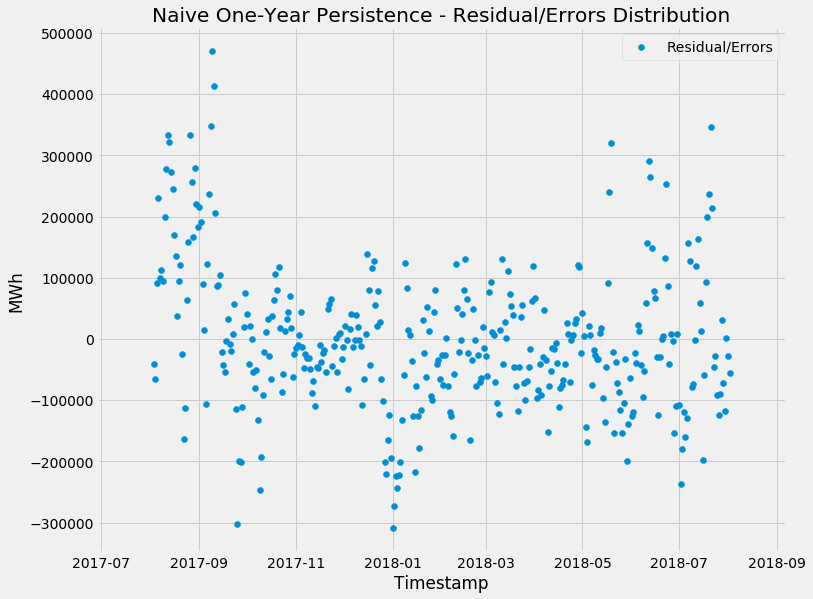

In [34]:
# First construct the residuals - basically the errors
naive_errors = test.copy()
naive_errors['PJME_MW_PREDICTION'] = baseline_prediction['PJME_MW']
naive_errors['error'] = naive_errors['PJME_MW_PREDICTION'] - naive_errors['PJME_MW']

# Let's visually see the errors via scatterplot
plt.scatter(naive_errors.index, naive_errors['error'], label='Residual/Errors')

# Plot Labels, Legends etc
plt.title('Naive One-Year Persistence - Residual/Errors Distribution')
plt.xlabel("Timestamp")
plt.ylabel("MWh")
plt.legend(loc='best')

plt.show()

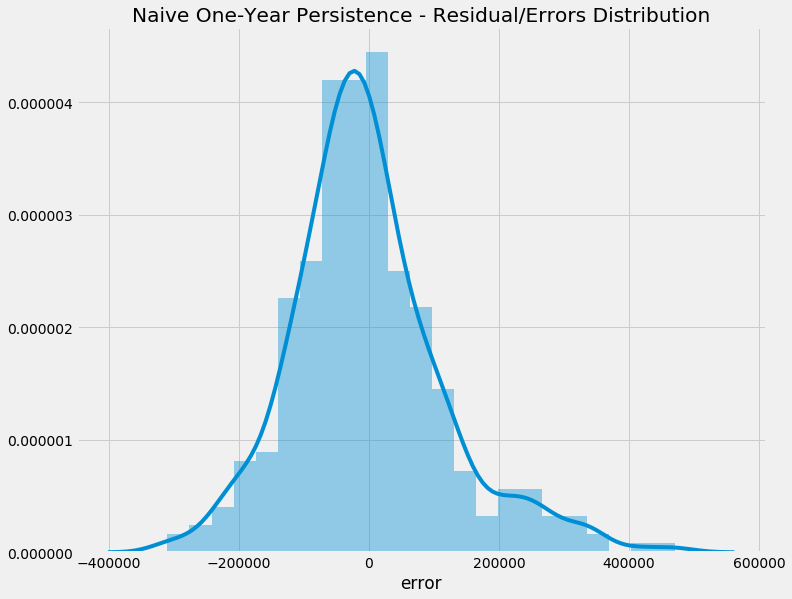

In [35]:
# Plot Histogram with Kernel Density Estimation (KDE)
sns.distplot(naive_errors['error'], kde=True);

# Plot Labels, Legends etc
plt.title('Naive One-Year Persistence - Residual/Errors Distribution')
plt.show()

The naive forecast actually is quite normally distributed, in terms of its errors, The errors  errors are converging closer to 0.

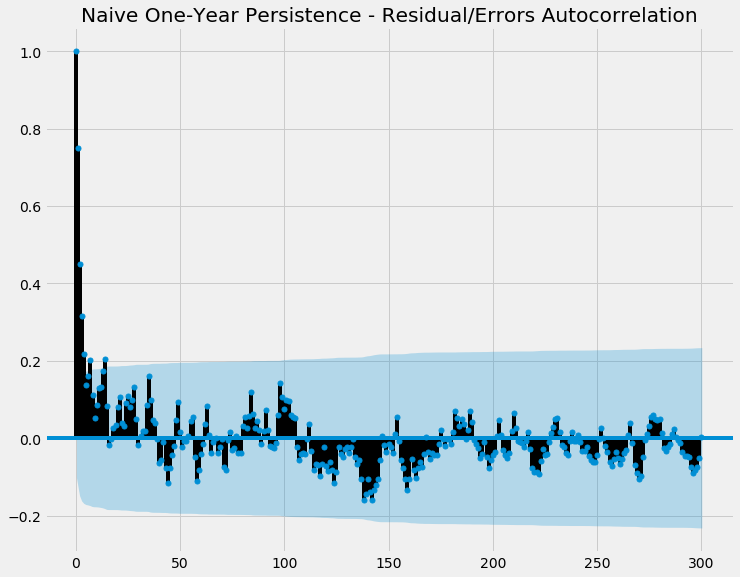

In [36]:
from statsmodels.graphics.tsaplots import plot_acf

# Plot the acf function
plot_acf(naive_errors['error'],lags=300) #alpha 1 suppresses CI

plt.title('Naive One-Year Persistence - Residual/Errors Autocorrelation')
plt.show()

## **Holtwinters Triple Exponential Smoothing**

Next we will use a time series forecasting model that takes advantage of the above identified components.

This is known as a 'generative additive model', as the final forecast value is 'adding' together multiple components.

The 'Triple' refers to the three components:

1. Level
2. Trend
3. Seasonality

Holtwinters works really well when the data is seasonal and has trends.

'Smoothing' basically means more weight is put on more recent data compared to the past.

Note the main hyperparameters for the model are:

- Additive vs Multiplicative (ie 'add' or 'mul')
- Box Cox - to use box cox log transformation to reduce the 'noise' of the data
- Alpha - smoothing factor between 0 and 1. 1 means will always take yesterday's value (naive forecasting). 0 means take simple average of past.

**Additive** means the formula looks more like this: Data = Level + Trend + Seasonality while **Multiplicative** means the formula looks more like this: Data = Level x Trend x Seasonality

We are using Box-Cox as heteroskedatic test before showed data requires dampening to reduce extremes.

In [37]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# First we split it up between train and test
htrain = train['PJME_MW'] # HWES takes series, not DF
htest = test['PJME_MW'] # HWES takes series, not DF

model = ExponentialSmoothing(
    htrain
    ,trend='add'
    ,seasonal='add'
    ,freq='D'
    ,seasonal_periods=90 #Default is auto estimated - 4 is quarterly and 7 is weekly
).fit(
    optimized=True # Default is True - auto estimates the other parameters using Grid Search
    ,use_basinhopping=True # Uses Basin Hopping Algorithm for optimising parameters
    ,use_boxcox='log' #Boxcox transformation via log
    #,smoothing_level= # Alpha
    #,smoothing_slope= # Beta
    #,smoothing_seasonal= # Gamma
)

HWES_prediction = model.predict(start=htest.index[0], end=htest.index[-1])
HWES_prediction = HWES_prediction.to_frame().rename(columns={0: 'PJME_MW'})

print("Finished training and predicting")

# Let's see what the model did
model.summary()

C:\Users\user\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


Finished training and predicting


Dep. Variable:,endog,No. Observations:,5693
Model:,ExponentialSmoothing,SSE,20150798081994.023
Optimized:,True,AIC,125361.542
Trend:,Additive,BIC,125986.359
Seasonal:,Additive,AICC,125364.870
Seasonal Periods:,90,Date:,"Fri, 16 Oct 2020"
Box-Cox:,True,Time:,10:52:03
Box-Cox Coeff.:,log,,
,coeff,code,optimized
smoothing_level,1.0000000,alpha,True
smoothing_slope,3.1136e-11,beta,True


In [38]:
# Evaluate it's performance using Mean Absolute Error (MAE)
from statsmodels.tools.eval_measures import meanabs

print("MAE HWES ADD: {:.20f}".format(meanabs(htest, HWES_prediction['PJME_MW'])))

MAE HWES ADD: 156201.70224104955559596419


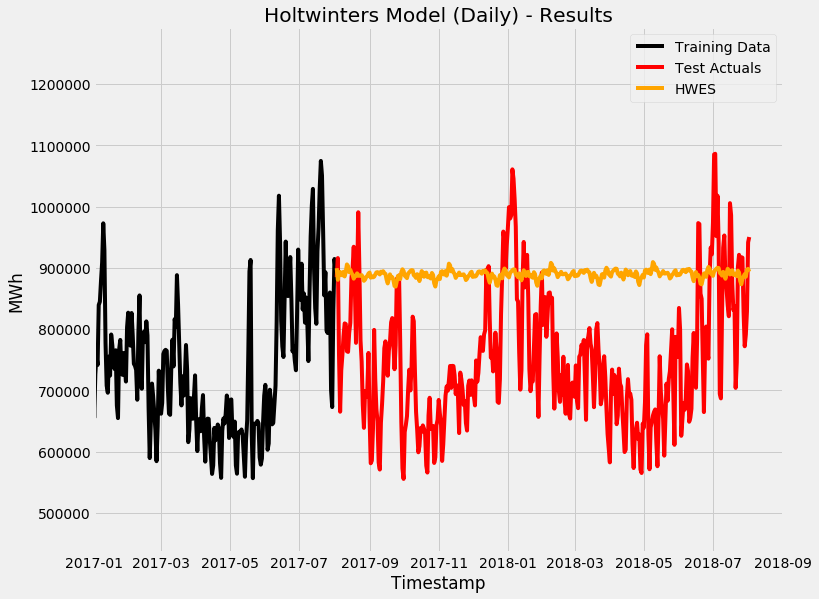

In [39]:
# Let's visually see the results
plt.plot(train, label='Training Data', color='black')
plt.plot(test, label='Test Actuals', color='red')
plt.plot(HWES_prediction['PJME_MW'], label='HWES', color='orange')

# Plot Labels, Legends etc
plt.xlabel("Timestamp")
plt.ylabel("MWh")
plt.legend(loc='best')
plt.title('Holtwinters Model (Daily) - Results')

# For clarify, let's limit to only 2017 onwards
plt.xlim(datetime(2017, 1, 1),datetime(2018, 9, 1))

plt.show()


Compared to the baseline model, the Holtwinters Model performs way worse.

## **XGBoost - Ensemble Learning**

Extreme Gradient Boosting: XGBoost has gained in popularity recently by being quite good at predicting many different types of problems.

Normally with decision-tree models, you would get the data and create one tree for it. This of course means it is very prone to overfitting and being confused by the unique tendencies of the past data.

To overcome this, you do 'gradient boosting'. At a very high-level, it is analogous to the algorithm creating a decision tree to try to predict the result, figure out how wrong it was, and then create another tree that learns from the first one's 'mistakes'.

This process is then repeated a few hundreds or even a few thousand times, with each tree being 'boosted' by the prior one's mistakes. The algorithm keeps going until it stops improving itself.


**Feature Engineering**

Most machine learning models don't 'look back' to prior values. Essentially if you have a table, each 'row' is an independent data point and the ML model doesn't consider the prior row's data.

This is problematic for time series data.

To address this issue, we use feature engineering to create additional features - in this case, I created 365 extra columns each prior day. Today minus 1 day, Today minus 2 days ... until Today minus 365 days.


In [41]:
# Feature Engineering first

def preprocess_xgb_data(df, lag_start=1, lag_end=365):
    '''
    Takes data and preprocesses for XGBoost.
    
    :param lag_start default 1 : int
        Lag window start - 1 indicates one-day behind
    :param lag_end default 365 : int
        Lag window start - 365 indicates one-year behind
        
    Returns tuple : (data, target)
    '''
    # Default is add in lag of 365 days of data - ie make the model consider 365 days of prior data
    for i in range(lag_start,lag_end):
        df[f'PJME_MW {i}'] = df.shift(periods=i, freq='D')['PJME_MW']

    df.reset_index(inplace=True)

    # Split out attributes of timestamp - hopefully this lets the algorithm consider seasonality
    df['date_epoch'] = pd.to_numeric(df['Datetime']) # Easier for algorithm to consider consecutive integers, rather than timestamps
    df['dayofweek'] = df['Datetime'].dt.dayofweek
    df['dayofmonth'] = df['Datetime'].dt.day
    df['dayofyear'] = df['Datetime'].dt.dayofyear
    df['weekofyear'] = df['Datetime'].dt.weekofyear
    df['quarter'] = df['Datetime'].dt.quarter
    df['month'] = df['Datetime'].dt.month
    df['year'] = df['Datetime'].dt.year
    
    x = df.drop(columns=['Datetime', 'PJME_MW']) #Don't need timestamp and target
    y = df['PJME_MW'] # Target prediction is the load
    
    return x, y

In [42]:
example_data = train.copy() #Otherwise it becomes a pointer

example_x, example_y = preprocess_xgb_data(example_data)

example_x.head(10)


,PJME_MW 1,PJME_MW 2,PJME_MW 3,PJME_MW 4,PJME_MW 5,PJME_MW 6,PJME_MW 7,PJME_MW 8,PJME_MW 9,PJME_MW 10,...,PJME_MW 363,PJME_MW 364,date_epoch,dayofweek,dayofmonth,dayofyear,weekofyear,quarter,month,year
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,1009929600000000000,2,2,2,1,1,1,2002
1,822277.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,1010016000000000000,3,3,3,1,1,1,2002
2,828285.0,822277.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,1010102400000000000,4,4,4,1,1,1,2002
3,809171.0,828285.0,822277.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,1010188800000000000,5,5,5,1,1,1,2002
4,729723.0,809171.0,828285.0,822277.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,1010275200000000000,6,6,6,1,1,1,2002
5,727766.0,729723.0,809171.0,828285.0,822277.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,1010361600000000000,0,7,7,2,1,1,2002
6,800012.0,727766.0,729723.0,809171.0,828285.0,822277.0,NaN,NaN,NaN,NaN,...,NaN,NaN,1010448000000000000,1,8,8,2,1,1,2002
7,824710.0,800012.0,727766.0,729723.0,809171.0,828285.0,822277.0,NaN,NaN,NaN,...,NaN,NaN,1010534400000000000,2,9,9,2,1,1,2002
8,810628.0,824710.0,800012.0,727766.0,729723.0,809171.0,828285.0,822277.0,NaN,NaN,...,NaN,NaN,1010620800000000000,3,10,10,2,1,1,2002
9,755317.0,810628.0,824710.0,800012.0,727766.0,729723.0,809171.0,828285.0,822277.0,NaN,...,NaN,NaN,1010707200000000000,4,11,11,2,1,1,2002


Now we need to split the time series between training and test - like what we did before.

Cross validation is harder in this case, as the datasets need to be sequential.

We will also need to specify features and labels (ie the target we want to predict).

In [44]:
xtrain = train.copy() #Otherwise it becomes a pointer
xtest = test.copy() # Otherwise it becomes a pointer

train_feature, train_label = preprocess_xgb_data(xtrain)
test_feature, test_label = preprocess_xgb_data(xtest)


As a tree-based algorithm, generally XGBoost doesn't handle trends in data well compared to linear models. However, given as shown above in the ADF test, the data is stationary, trend is not really an issue and we can proceed. Otherwise we would need to de-trend the data first as part of preprocessing.

In [45]:
#Train and predict using XGBoost
from xgboost import XGBRegressor
from sklearn.model_selection import KFold, train_test_split

# We will try with 1000 trees and a maximum depth of each tree to be 5
# Early stop if the model hasn't improved in 100 rounds
model = XGBRegressor(
    max_depth=6 # Default - 6
    ,n_estimators=1000
    ,booster='gbtree'
    ,colsample_bytree=1 # Subsample ratio of columns when constructing each tree - default 1
    ,eta=0.3 # Learning Rate - default 0.3
    ,importance_type='weight' # Default is gain
)
model.fit(
    train_feature
    ,train_label
    ,eval_set=[(train_feature, train_label)]
    ,eval_metric='mae'
    ,verbose=True
    ,early_stopping_rounds=100 # Stop after 100 rounds if it doesn't after 100 times
)

#predictions
xtest['PJME_MW Prediction'] = model.predict(test_feature)
XGB_prediction = xtest[['Datetime', 'PJME_MW Prediction']].set_index('Datetime')



[0]	validation_0-mae:540225.50000
Will train until validation_0-mae hasn't improved in 100 rounds.
[1]	validation_0-mae:378510.09375
[2]	validation_0-mae:265279.56250
[3]	validation_0-mae:186089.98438
[4]	validation_0-mae:130587.29688
[5]	validation_0-mae:91838.67969
[6]	validation_0-mae:65258.05078
[7]	validation_0-mae:47765.44922
[8]	validation_0-mae:37170.40234
[9]	validation_0-mae:30951.17578
[10]	validation_0-mae:27408.63281
[11]	validation_0-mae:25318.39648
[12]	validation_0-mae:24070.56055
[13]	validation_0-mae:23436.92578
[14]	validation_0-mae:23151.02539
[15]	validation_0-mae:22539.75391
[16]	validation_0-mae:22244.66211
[17]	validation_0-mae:21999.89453
[18]	validation_0-mae:21553.04492
[19]	validation_0-mae:21399.83789
[20]	validation_0-mae:21230.13867
[21]	validation_0-mae:20937.04102
[22]	validation_0-mae:20644.13672
[23]	validation_0-mae:20310.22656
[24]	validation_0-mae:20162.49805
[25]	validation_0-mae:19962.44922
[26]	validation_0-mae:19550.36523
[27]	validation_0-mae:

[240]	validation_0-mae:1700.53589
[241]	validation_0-mae:1673.00842
[242]	validation_0-mae:1653.96130
[243]	validation_0-mae:1637.49585
[244]	validation_0-mae:1629.50830
[245]	validation_0-mae:1613.86877
[246]	validation_0-mae:1593.50073
[247]	validation_0-mae:1579.47302
[248]	validation_0-mae:1567.17859
[249]	validation_0-mae:1545.13965
[250]	validation_0-mae:1516.78625
[251]	validation_0-mae:1493.99512
[252]	validation_0-mae:1470.69421
[253]	validation_0-mae:1456.10913
[254]	validation_0-mae:1433.59888
[255]	validation_0-mae:1407.40210
[256]	validation_0-mae:1404.54285
[257]	validation_0-mae:1393.62305
[258]	validation_0-mae:1386.48486
[259]	validation_0-mae:1374.00354
[260]	validation_0-mae:1356.41602
[261]	validation_0-mae:1345.82519
[262]	validation_0-mae:1326.10864
[263]	validation_0-mae:1313.79443
[264]	validation_0-mae:1304.13550
[265]	validation_0-mae:1276.43311
[266]	validation_0-mae:1272.48242
[267]	validation_0-mae:1266.83679
[268]	validation_0-mae:1262.24243
[269]	validati

[487]	validation_0-mae:120.89288
[488]	validation_0-mae:119.15639
[489]	validation_0-mae:117.95608
[490]	validation_0-mae:116.48309
[491]	validation_0-mae:115.11705
[492]	validation_0-mae:113.94749
[493]	validation_0-mae:112.33943
[494]	validation_0-mae:111.97024
[495]	validation_0-mae:109.15353
[496]	validation_0-mae:108.40437
[497]	validation_0-mae:107.89700
[498]	validation_0-mae:106.55442
[499]	validation_0-mae:104.71826
[500]	validation_0-mae:103.56870
[501]	validation_0-mae:101.87488
[502]	validation_0-mae:100.63086
[503]	validation_0-mae:99.38326
[504]	validation_0-mae:97.99892
[505]	validation_0-mae:96.36897
[506]	validation_0-mae:95.27583
[507]	validation_0-mae:93.98514
[508]	validation_0-mae:93.00138
[509]	validation_0-mae:92.72046
[510]	validation_0-mae:91.78583
[511]	validation_0-mae:90.81427
[512]	validation_0-mae:90.26220
[513]	validation_0-mae:88.50124
[514]	validation_0-mae:87.11942
[515]	validation_0-mae:86.18510
[516]	validation_0-mae:84.85334
[517]	validation_0-mae:8

[743]	validation_0-mae:9.93861
[744]	validation_0-mae:9.75084
[745]	validation_0-mae:9.67935
[746]	validation_0-mae:9.54629
[747]	validation_0-mae:9.42939
[748]	validation_0-mae:9.27485
[749]	validation_0-mae:9.18633
[750]	validation_0-mae:9.08604
[751]	validation_0-mae:8.99968
[752]	validation_0-mae:8.98940
[753]	validation_0-mae:8.89865
[754]	validation_0-mae:8.84176
[755]	validation_0-mae:8.79932
[756]	validation_0-mae:8.78830
[757]	validation_0-mae:8.72482
[758]	validation_0-mae:8.68614
[759]	validation_0-mae:8.55438
[760]	validation_0-mae:8.45113
[761]	validation_0-mae:8.35815
[762]	validation_0-mae:8.33580
[763]	validation_0-mae:8.28941
[764]	validation_0-mae:8.20595
[765]	validation_0-mae:8.12646
[766]	validation_0-mae:7.99190
[767]	validation_0-mae:7.96091
[768]	validation_0-mae:7.92008
[769]	validation_0-mae:7.83263
[770]	validation_0-mae:7.75103
[771]	validation_0-mae:7.62838
[772]	validation_0-mae:7.53340
[773]	validation_0-mae:7.51062
[774]	validation_0-mae:7.42082
[775]	va

In [46]:
from sklearn.metrics import mean_absolute_error

print("MAE XGB: {:.20f}".format(mean_absolute_error(test_label, XGB_prediction['PJME_MW Prediction'])))

MAE XGB: 44861.70873287671565776691


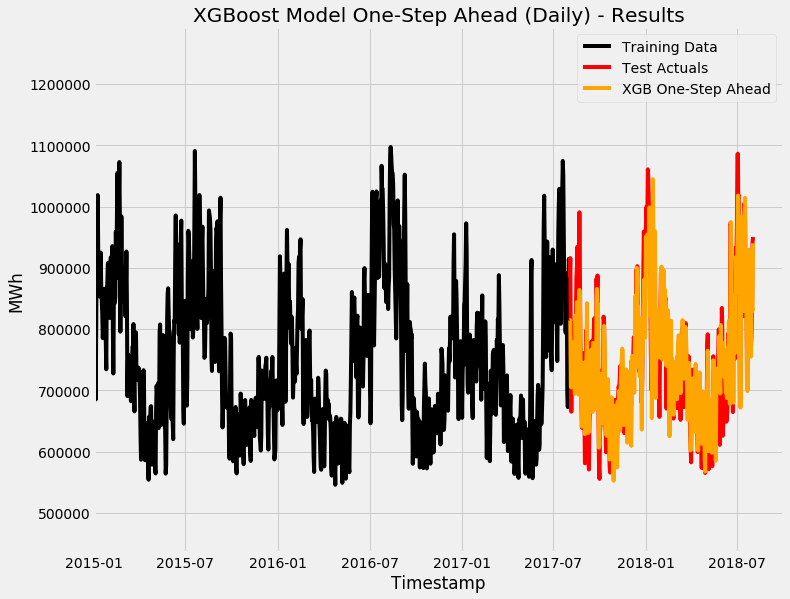

In [49]:
# Let's visually see the results
plt.plot(train, label='Training Data', color='black')
plt.plot(test, label='Test Actuals', color='red')
plt.plot(XGB_prediction, label='XGB One-Step Ahead', color='orange')

# Plot Labels, Legends etc
plt.xlabel("Timestamp")
plt.ylabel("MWh")
plt.legend(loc='best')
plt.title('XGBoost Model One-Step Ahead (Daily) - Results')

# For clarity, let's limit to only 2015 onwards
plt.xlim(datetime(2015, 1, 1),datetime(2018, 10, 1))


plt.show()

The results of the model are fairly accurate!

However, caveat is that because the model knows about yesterday's value. Therefore, the 'forecast horizon' (ie the maximum length of time it can predict into the future) is only 1 day. This is also known as a 'One-Step Ahead Forecast'.

If you only have yesterday's value, you can only predict today's value. If you only have today's value, you can only predict tomorrow's value.

Now let's see what the algorithm considered most important - we'll grab the Top 10 features by weight.

The weight is the percentage representing the relative number of times a particular feature occurs in the trees of the model. It's a rough way of saying the more times you reference a particular feature, the more likely it is important.

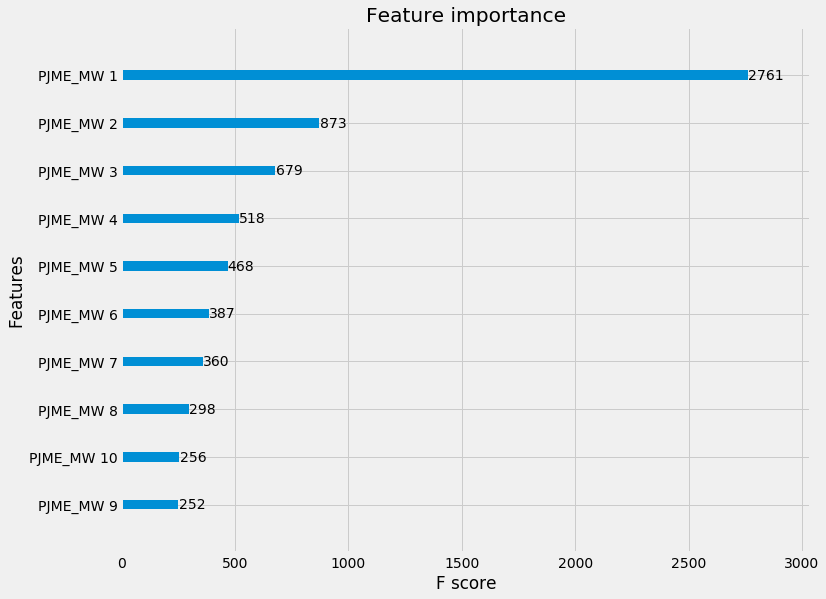

In [50]:
import xgboost as xgb

xgb.plot_importance(model, max_num_features=10, importance_type='weight') # "weight” is the number of times a feature appears in a tree

plt.show()

Seems like yesterday's value is the biggest factor in determining today's value! This, again, makes sense, given how the autocorrelation function showed yesterday's value had the biggest correlation with today's value.

**Improving the XGBoost Model: -Including Lag without Data Leakage**

The aim is to make the XGBoost model move more than one-step ahead. 

In [51]:
# So because we need the lag data, we need to preprocess then do the split
all_data = daily_data.copy()

feature, label = preprocess_xgb_data(all_data, lag_start=365, lag_end=720)

# We will aim for a 12 month forecast horizon (ie predict the last 365 days in the dataset)
train_feature = feature[:-365]
train_label = label[:-365]

test_feature = feature[-365:]
test_label = label[-365:]

In [56]:
#Train and predict using XGBoost
from xgboost import XGBRegressor
from sklearn.model_selection import KFold, train_test_split

# We will try with 1000 trees and a maximum depth of each tree to be 
# Early stop if the model hasn't improved in 100 rounds
model = XGBRegressor(
    max_depth=6 # Default - 6
    ,n_estimators=1000
    ,booster='gbtree'
    ,colsample_bytree=1 # Subsample ratio of columns when constructing each tree - default 1
    ,eta=0.3 # Learning Rate - default 0.3
    ,importance_type='gain' # Default is gain
)
model.fit(
    train_feature
    ,train_label
    ,eval_set=[(train_feature, train_label)]
    ,eval_metric='mae'
    ,verbose=False
    ,early_stopping_rounds=100 # Stop after 100 rounds if it doesn't after 100 times
)

xtest['PJME_MW'] = model.predict(test_feature)
XGB_prediction_no_lag = xtest[['Datetime', 'PJME_MW Prediction']].set_index('Datetime')
XGB_prediction_no_lag = XGB_prediction_no_lag.rename(columns={'PJME_MW Prediction': 'PJME_MW'})

In [ ]:
# Let's visually see the results
plt.plot(train, label='Training Data', color='black')
plt.plot(test, label='Test Actuals', color='red')
plt.plot(XGB_prediction_no_lag, label='XGB No Lag', color='orange')

# Plot Labels, Legends etc
plt.xlabel("Timestamp")
plt.ylabel("MWh")
plt.legend(loc='best')
plt.title('XGBoost Model (Daily) - Results')

# For clarify, let's limit to only 2015 onwards
plt.xlim(datetime(2015, 1, 1),datetime(2018, 10, 1))

plt.show()

Checking the feature importtance- by gain

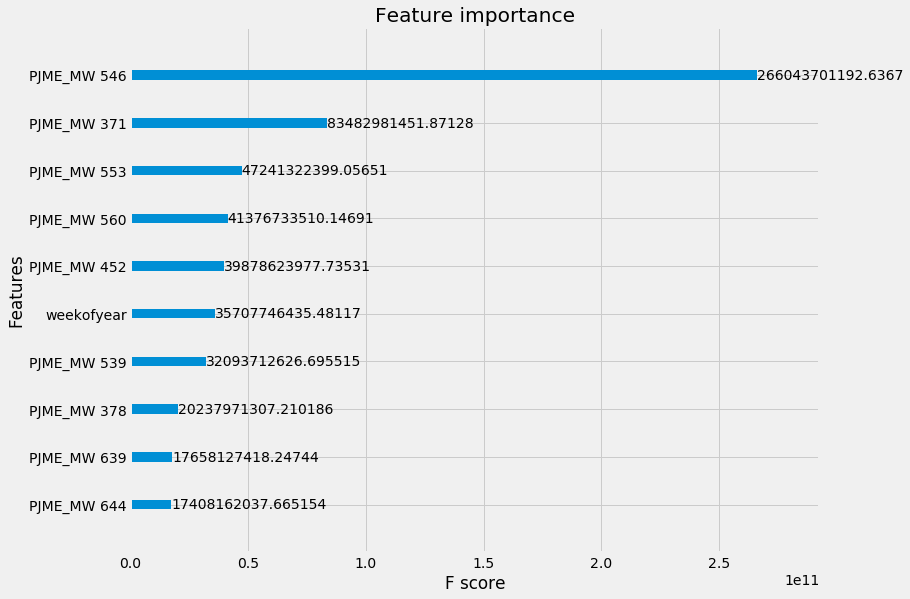

In [54]:
import xgboost as xgb

xgb.plot_importance(model, max_num_features=10, importance_type='gain') # gain is how much each feature contributed to 'improvement' of tree

plt.show()


Looking at the distribution of the errors - The ideal state is the errors are centred around zero (meaning the model doesn't particularly over or under forecast in a biased way)

In [66]:
# First construct the residuals - basically the errors
xgboost_errors = XGB_prediction_no_lag.copy()
xgboost_errors['PJME_MW_ACTUAL'] = test.copy()
xgboost_errors['error'] = xgboost_errors['PJME_MW'] - xgboost_errors['PJME_MW_ACTUAL']


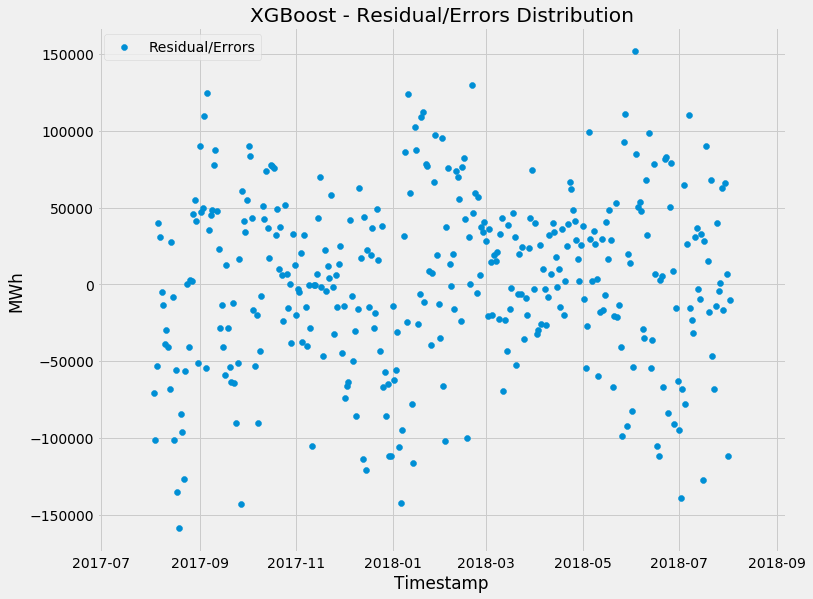

In [67]:
# Let's visually see the errors via scatterplot
plt.scatter(xgboost_errors.index, xgboost_errors['error'], label='Residual/Errors')

# Plot Labels, Legends etc
plt.title('XGBoost - Residual/Errors Distribution')
plt.xlabel("Timestamp")
plt.ylabel("MWh")
plt.legend(loc='best')

plt.show()

Text(0.5, 1.0, 'XGBoost - Residual/Errors Distribution')

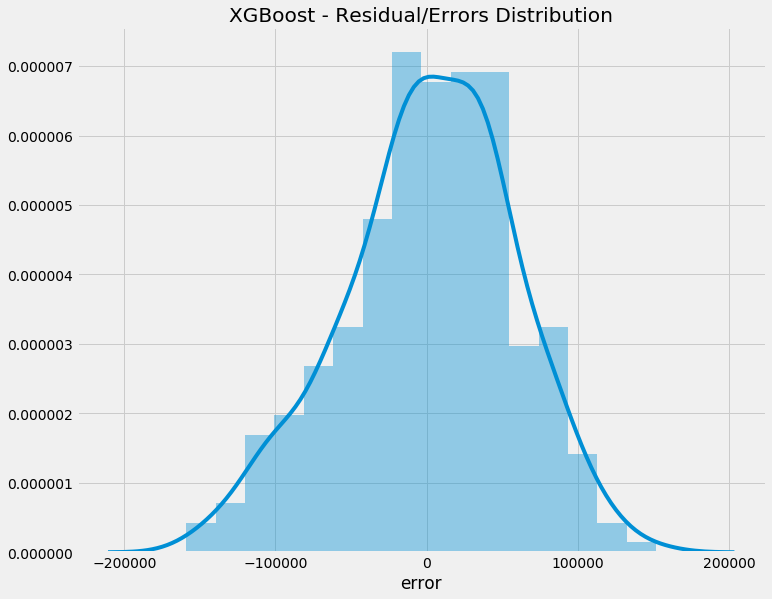

In [68]:
# Plot Histogram with Kernel Density Estimation (KDE)
sns.distplot(xgboost_errors['error'], kde=True);

# Plot Labels, Legends etc
plt.title('XGBoost - Residual/Errors Distribution')

So looking quite good - you can see some forecasts were pretty off (particularly for spikes), but overall, it seems the model treats overs and under equal.

Next let's look at the autocorrelation of the errors

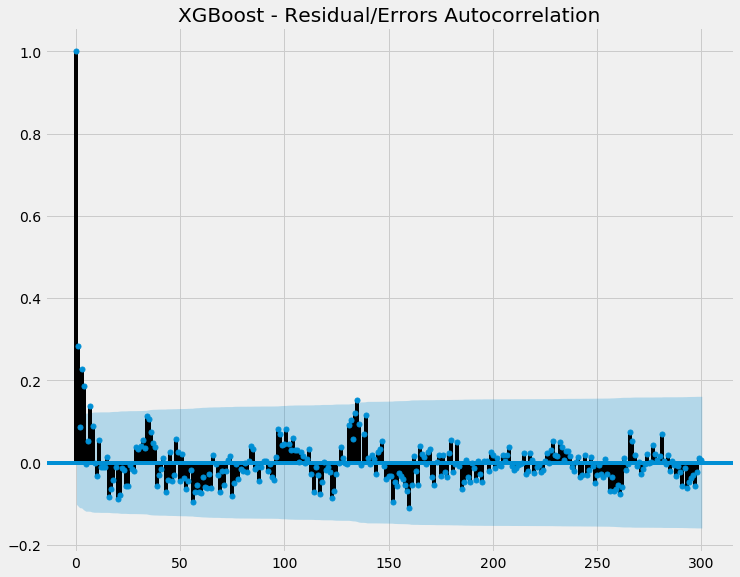

In [69]:
from statsmodels.graphics.tsaplots import plot_acf

# Plot the acf function
plot_acf(xgboost_errors['error'],lags=300) #alpha 1 suppresses CI

plt.title('XGBoost - Residual/Errors Autocorrelation')
plt.show()

So most of the points are within the shaded blue (ie confidence interval), indicating there's no statistically significant autocorrelation going on. This is good, as if there was autocorrelation with our errors, it means there's some autocorrelation our model is failing to capture.

## **Lasso Regression(L1)**

LASSO regression incorporates regularisation and feature selection into its algorithm. Regularisation is a technique used in regression algorithms to avoid overfitting. For LASSO, this means it will penalise the 'irrelevant' features by effectively by 'zeroing' out those features (by multiplying it with a 0 coefficient).

The main hyperparameter to tune is the penalty factor (i.e. lambda or alpha). A factor of 0 means no penalisation occurs, and it effectively just does an Ordinary-Least-Squares (OLS) regression.

Since we've already set up all the train-test split (as well as feature engineering) in the prior XGBoost model, we can just re-use it.

However, like the decision tree-based XGBoost, lasso regression is sensitive to scale. Therefore, we also need to scale the data.

In [70]:
# So because we need the lag data, we need to preprocess then do the split
all_data = daily_data.copy()

# Create train test dataset using XGBoost preprocessing (365 days top 720 days lag)
feature, label = preprocess_xgb_data(all_data, lag_start=365, lag_end=720)

# We will aim for a 12 month forecast horizon (ie predict the last 365 days in the dataset)
train_feature = feature[:-365]
train_label = label[:-365]

test_feature = feature[-365:]
test_label = label[-365:]

train_feature = train_feature.fillna(0)
test_feature = test_feature.fillna(0)

# train_feature.drop(columns=['date_epoch']) #Don't need timestamp
# test_feature.drop(columns=['date_epoch']) #Don't need timestamp

# Scale dataset
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

train_feature_scaled = scaler.fit_transform(train_feature)
test_feature_scaled = scaler.transform(test_feature)

In [72]:
# Create Time Series k-fold cross validation
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5) # in this case 5-fold

#Train and predict using LASSO
from sklearn.linear_model import LassoCV

model = LassoCV(
    #hyperparameter tuning_the penalty factor
    alphas=[0.0001, 0.0003, 0.0006, 0.001, 0.003, 0.006, 0.01, 0.03, 0.06, 0.1,0.3, 0.6, 1]
    ,max_iter=1000 # 1000 iterations
    ,random_state=42
    ,cv=tscv
    ,verbose=False
)
model.fit(train_feature_scaled,train_label)
LASSO_prediction = xtest.copy()
LASSO_prediction['PJME_MW Prediction'] = model.predict(test_feature_scaled)
LASSO_prediction = LASSO_prediction[['Datetime', 'PJME_MW Prediction']].set_index('Datetime')
LASSO_prediction = LASSO_prediction.rename(columns={'PJME_MW Prediction': 'PJME_MW'})

LASSO_prediction

C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2471334186675.748, tolerance: 1101472714.228882
  tol, rng, random, positive)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2350657788352.601, tolerance: 1101472714.228882
  tol, rng, random, positive)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2433061677395.027, tolerance: 1101472714.228882
  tol, rng, random, positive)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might wa

C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7797126046851.364, tolerance: 3404771981.0370994
  tol, rng, random, positive)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7804990346288.914, tolerance: 3404771981.0370994
  tol, rng, random, positive)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7809799530204.076, tolerance: 3404771981.0370994
  tol, rng, random, positive)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might

C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12720826010986.67, tolerance: 5870527269.761591
  tol, rng, random, positive)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12715513155510.078, tolerance: 5870527269.761591
  tol, rng, random, positive)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12709709200801.906, tolerance: 5870527269.761591
  tol, rng, random, positive)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might 

,PJME_MW
Datetime,
2017-08-03,897902.448153
2017-08-04,895231.527038
2017-08-05,838513.412067
2017-08-06,801941.014021
2017-08-07,861500.491963
...,...
2018-07-29,806937.015262
2018-07-30,875589.676064
2018-07-31,900495.908037


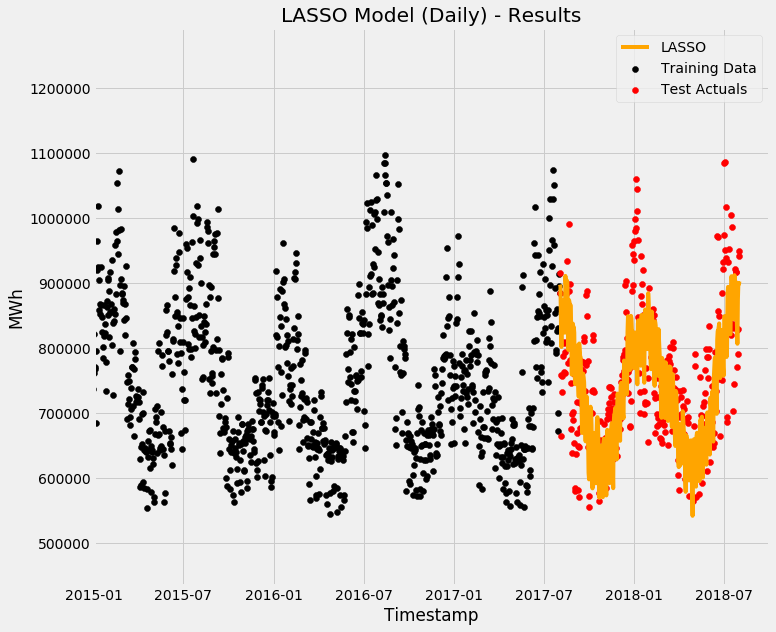

In [75]:
# Let's visually see the results
plt.scatter(x=train.index, y=train['PJME_MW'], label='Training Data', color='black')
plt.scatter(x=test.index, y=test['PJME_MW'], label='Test Actuals', color='red')
plt.plot(LASSO_prediction, label='LASSO', color='orange')

# Plot Labels, Legends etc
plt.xlabel("Timestamp")
plt.ylabel("MWh")
plt.legend(loc='best')
plt.title('LASSO Model (Daily) - Results')
plt.tight_layout()
plt.grid(True)

# For clarity, let's limit to only 2015 onwards
plt.xlim(datetime(2015, 1, 1),datetime(2018, 10, 1))         

plt.show()

Next let's see feature importance by way of coefficients - we'll only get Top 10.

Remember, LASSO will 'zero-out' irrelevant features, so in this case, these are the Top 10 features that LASSO considers are most important

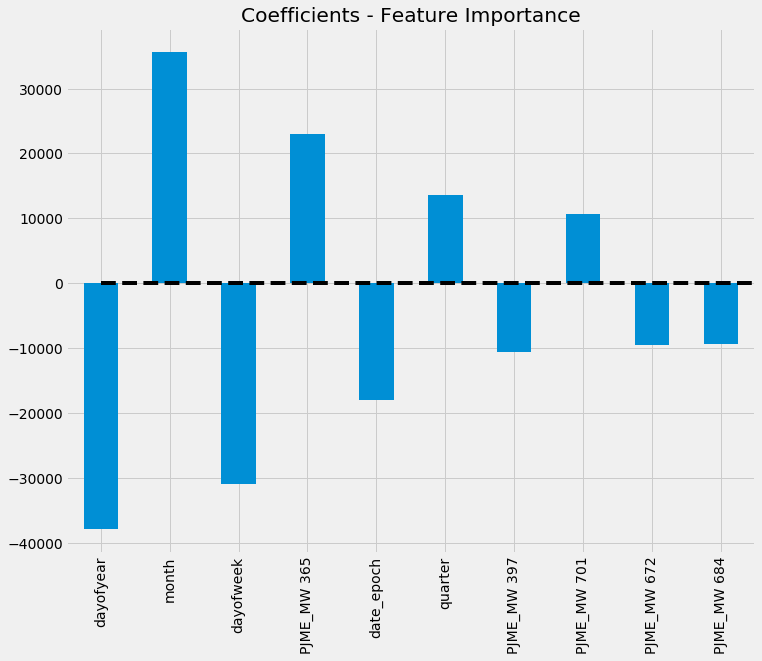

In [76]:
# Plot feature importance by way of coefficients    

# Create DataFrame
coefs = pd.DataFrame(model.coef_, train_feature.columns)
coefs.columns = ["coef"]

# Only grab the Top 10 Coefficients
coefs["abs"] = coefs.coef.apply(np.abs)
coefs = coefs.sort_values(by="abs", ascending=False).head(10)
coefs = coefs.drop(["abs"], axis=1)

# Plot
coefs.coef.plot(kind='bar')

# Plot title and x-axis line
plt.title("Coefficients - Feature Importance")
plt.hlines(y=0, xmin=0, xmax=len(coefs), linestyles='dashed')

So LASSO is producing half decent results! Now let's have a look at the residuals/errors.

First let's look at the distribution of the errors - remember, the ideal state is the errors are centred around zero (meaning the model doesn't particularly over or under forecast in a biased way)

In [77]:
# First construct the residuals - basically the errors
lasso_errors = LASSO_prediction.copy()
lasso_errors['PJME_MW_ACTUAL'] = test.copy()
lasso_errors['error'] = lasso_errors['PJME_MW'] - lasso_errors['PJME_MW_ACTUAL']

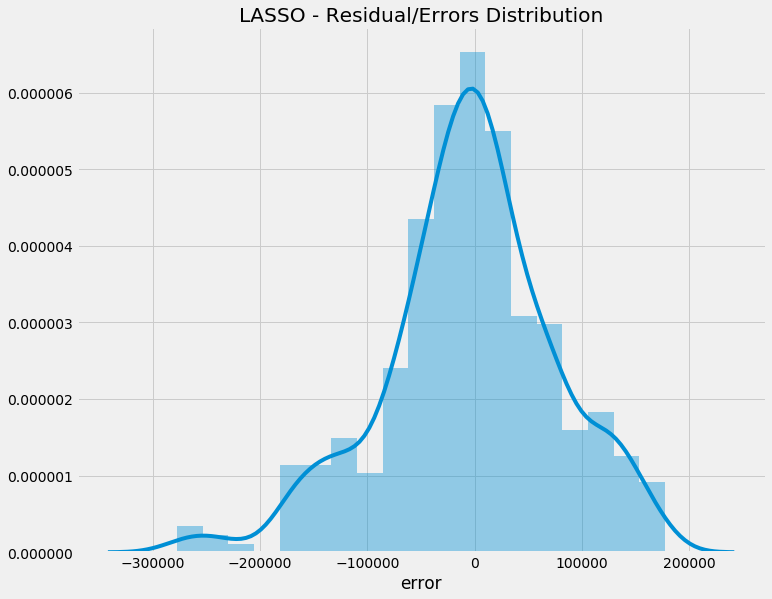

In [78]:
# Plot Histogram with Kernel Density Estimation (KDE)
sns.distplot(lasso_errors['error'], kde=True)

# Plot Labels, Legends etc
plt.title('LASSO - Residual/Errors Distribution')

plt.show()

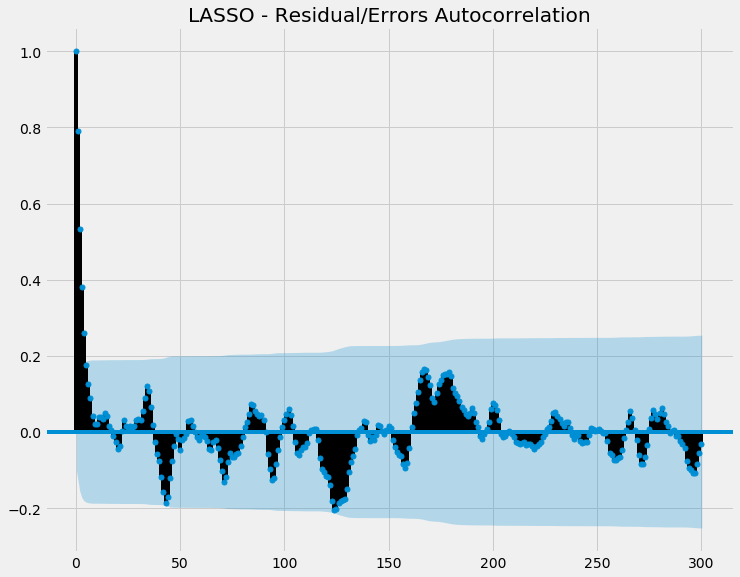

In [79]:
# Plot the acf function
plot_acf(lasso_errors['error'],lags=300) #alpha 1 suppresses CI

plt.title('LASSO - Residual/Errors Autocorrelation')
plt.show()

# **SARIMA**

Seasonal Autoregressive Intergrated Moving Avergae: The conventional ARIMA model assumes that the historical data are useful to predict the value at the next time step. In this case, this is somewhat true, as the ACF plot before showed past value is somewhat correlated with today's value.

ARIMA basically integrates two naive forecasting techniques together:

1. **Autoregression** - Uses one or more past values to forecast the future. The number of values used is known as the 'order' (e.g. order 2 means yesterday and day before's value is used)

2. **Integrating** - the part that reduces seasonality. How many degrees of differencing is done to reduce seasonality is the 'order'.

3. **Moving Average** - Uses the Moving Average of the historical data to adjust the forecasted values. This has a 'smoothing' effect on the past data, as it uses the moving average rather than the actual values of the past. The number of days in the moving average window is the 'order'.

SARIMA then adds a 'seasonality' flavour to the ARIMA model - it factors in trends and seasonality, as explained above.

The main hyperparameters are SARIMAX(p,d,q)(P,D,Q,m):

- autoregression order (p)
- Integrating order (d)
- moving average window (q)
- Seasonal autoregressive order (P)
- Seasonal difference order (D)
- Seasonal moving average order (Q)
- number of time steps for a single seasonal period (m)
The X is the exogenous (external) variables to the model - they are optional and for this model we won't use them.

Like Holtwinters, the training and testing data was split between 2002 to 2017 and 2017 to 2018.

The results were as follows:

In [80]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tools.eval_measures import meanabs

# Equivalent to R's Auto ARIMA to get the optimal parameters
#import pmdarima as pm
#model = pm.auto_arima(htrain, seasonal=True, stationary=True, stepwise=True, trace=True, suppress_warnings=True)

# First we split it up between train and test
htrain = train['PJME_MW'] # SARIMAX takes series, not DF
htest = test['PJME_MW'] # SARIMAX takes series, not DF

# Next define hyperparameters. Default is AR model (1,0,0)(0,0,0,0)
p = 1 # AR order
d = 0 # I degree
q = 1 # MA window
P = 0 # AR seasonal order
D = 1 # I seasonal order
Q = 2 # MA seasonal order
m = 6 # Seasonality period length

model = SARIMAX(
    htrain,
    order=(p, d, q),
    seasonal_order=(P, D, Q, m)
    ,enforce_stationarity=False
    ,enforce_invertibility=False
).fit(
    maxiter=50 # Default is 50
)

results = model.get_prediction(start=htest.index[0], end=htest.index[-1], dynamic=False)
SARIMA_prediction_CI = results.conf_int(alpha=(1-0.8)) # 80% CI
SARIMA_prediction = results.predicted_mean
SARIMA_prediction = SARIMA_prediction.to_frame().rename(columns={0: 'PJME_MW'})

# Evaluate it's performance using Mean Absolute Error (MAE)
print("Finished training and predicting. MAE SARIMA: {:.20f}. AIC: {}. Parameters: p,d,q,P,D,Q,m: ".format(meanabs(htest, SARIMA_prediction['PJME_MW']), model.aic), p,d,q,P,D,Q,m)

C:\Users\user\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Finished training and predicting. MAE SARIMA: 133374.15184878848958760500. AIC: 140973.93949430308. Parameters: p,d,q,P,D,Q,m:  1 0 1 0 1 2 6


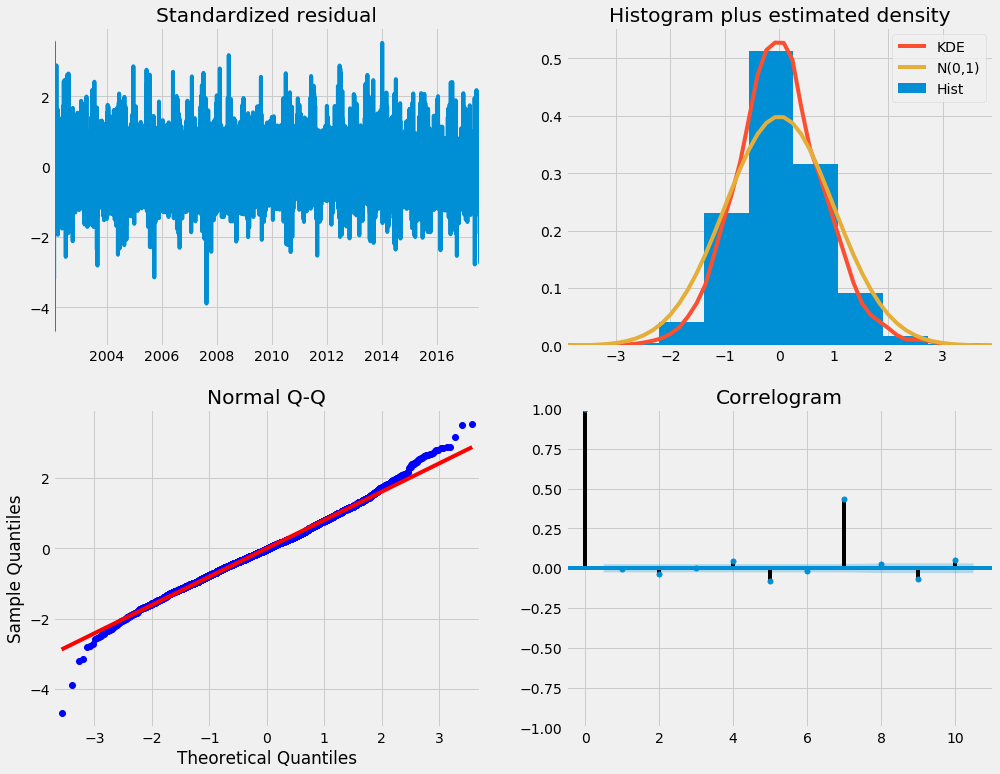

In [81]:
# Let's see what the model did
model.plot_diagnostics(figsize=(15, 12))
plt.show()

Importantly, the model should have the residuals uncorrelated and normally distributed (ie the mean should be zero). That is the, the centre point of the residuals should be zero and the distribution plot (KDE) should also be centred on 0.

In [82]:
# Evaluate it's performance using Mean Absolute Error (MAE)
from statsmodels.tools.eval_measures import meanabs

print("MAE SARIMA: {:.20f}".format(meanabs(htest, SARIMA_prediction['PJME_MW'])))


MAE SARIMA: 133374.15184878848958760500


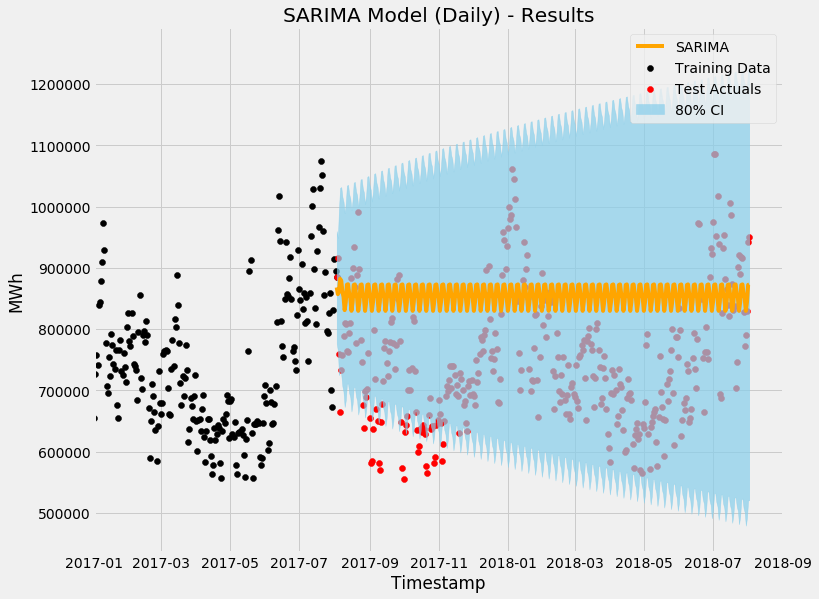

In [83]:
# Let's visually see the results
plt.scatter(x=train.index, y=train['PJME_MW'], label='Training Data', color='black')
plt.scatter(x=test.index, y=test['PJME_MW'], label='Test Actuals', color='red')
plt.plot(SARIMA_prediction['PJME_MW'], label='SARIMA', color='orange')

# Plot Confidence Interval
plt.fill_between(
    SARIMA_prediction.index,
    SARIMA_prediction_CI['lower PJME_MW'],
    SARIMA_prediction_CI['upper PJME_MW'],
    color='skyblue',
    alpha=0.7, # 70% transparency
    label='80% CI'
)

# Plot Labels, Legends etc
plt.xlabel("Timestamp")
plt.ylabel("MWh")
plt.legend(loc='best')
plt.title('SARIMA Model (Daily) - Results')

# For clarify, let's limit to only 2017 onwards
plt.xlim(datetime(2017, 1, 1),datetime(2018, 9, 1))

plt.show()

So you can see that despite some tuning, the results are not particularly good. The confidence interval is very big, indicating the model has is not 'confident' in the prediction either.



## **Prophet**

Facebook Prophet - is an open-source library that is also a generalised additive model (ie final result is made up of multiple components added together).

Unlike regular Generalised Linear Models, Facebook Prophet's uses a Bayesian curve fitting approach. The concept of Bayesian theorem is, at high level, trying to determine the probability of related events given knowledge/assumptions you already know (ie 'priors').

This is basically fancy talk for saying it focuses on finding a bunch of possible parameters and the probability of each one rather than finding fixed optimal values for the model. How certain (or uncertain) the model is about each possible parameter is known as the 'uncertainty interval' - the less data the model sees, the bigger the interval is.

The sources of uncertainty that Prophet's Bayesian approach aims to address are:

- Uncertainty of the predicted value
- Uncertainty of the trend and trend changes
- Uncertainty of additional noise

Prophet is different to SARIMA and HoltWinters, as it essentially decomposes time series differently by:

**Data = Trend +/x Seasonality +/x Holidays +/x Noise**

In Prophet, trend represents non-periodic changes while seasonality represents periodic changes. Where it differs from other statistic models like SARIMA and Holtwinters is Prophet factors in the uncertainty of trends changing.

Interestingly, Prophet fits a curve to each component independently (ie fits a regression for each component with time as independent variable). That is:

Trend - fits piece-wise linear/log curve Seasonality - uses fourier series Holidays - uses constant/fixed values Prophet reacts to changes in trends by 'changepoints' - that is sudden and abrupt changes in the trend. An example, is the release of a new electric car that will impact sale of petrol cars.

How 'reactive'/flexible Prophet is to changepoints will impact how much fluctation the model will do. For example, when the changepoint scale is to very high, it becomes very sensitive and any small changes to the trend will be picked up. Consequently, the sensitive model may detect spikes that won't amount to anything, while an insensitive model may miss spikes altogether.

The uncertainty of the predictions is determined by the number of changepoints and the flexibility of the changepoint allowed. In other words, if there were many changes in the past, there's likely going to be many changes in the future. Prophet gets the uncertainty by randomly sampling changepoints and seeing what happened before and after.

Furthermore, Prophet factors in seasonality by considering both its length (ie seasonal period) and its frequency (ie its 'fourier order').For example, if something keeps happening every week on Monday, the period is 7 days and its frequency is 52 times a year.

There's also a function for Prophet to consider additional factors (e.g. holidays), but for the purposes of this forecast we won't use it.

In [99]:
from fbprophet import Prophet

ftrain = train.reset_index().rename(columns={'Datetime':'ds', 'PJME_MW': 'y'}) # Prophet takes ds and y as column names only

model = Prophet(
    n_changepoints=25 # Default is 25
    ,changepoint_prior_scale=0.05 # Default is 0.05
    ,seasonality_mode='additive'
    ,interval_width=0.8 # CI - default is 0.8 or 80%
)
model.fit(ftrain)

# Create the future dataframe with date range that will be used to test accuracy
future_df = test.reset_index()['Datetime'].to_frame().rename(columns={"Datetime":'ds'})

# Predict the future
forecast = model.predict(future_df)
PROPHET_prediction = forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']][cutoff:]
PROPHET_prediction = PROPHET_prediction.rename(columns={'yhat': 'PJME_MW'})

print("Finished training and predicting")

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Finished training and predicting


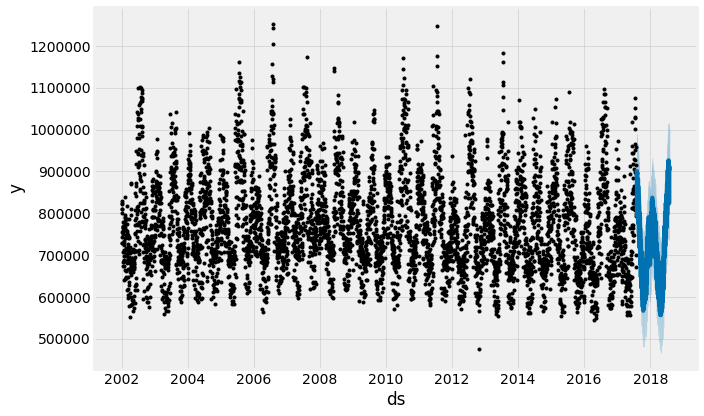

In [100]:
model.plot(forecast)

plt.show()

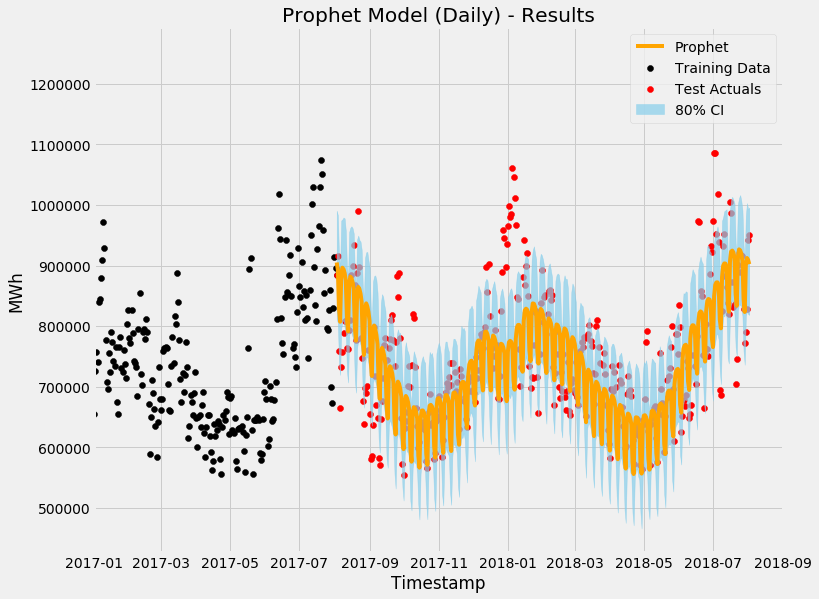

In [101]:
#zooming in on 2017 data
# Let's visually see the results
plt.scatter(x=train.index, y=train['PJME_MW'], label='Training Data', color='black')
plt.scatter(x=test.index, y=test['PJME_MW'], label='Test Actuals', color='red')
plt.plot(PROPHET_prediction['PJME_MW'], label='Prophet', color='orange')

# Plot Confidence Interval
plt.fill_between(
    PROPHET_prediction.index,
    PROPHET_prediction['yhat_lower'],
    PROPHET_prediction['yhat_upper'],
    color='skyblue',
    alpha=0.7, # 70% transparency
    label='80% CI'
)

# Plot Labels, Legends etc
plt.xlabel("Timestamp")
plt.ylabel("MWh")
plt.legend(loc='best')
plt.title('Prophet Model (Daily) - Results')

# For clarify, let's limit to only 2017 onwards
plt.xlim(datetime(2017, 1, 1),datetime(2018, 9, 1))

plt.show()

You can see the 80% confidence interval (in light blue), indicating the model is confident that 80% of the actual data will land in that predicted range

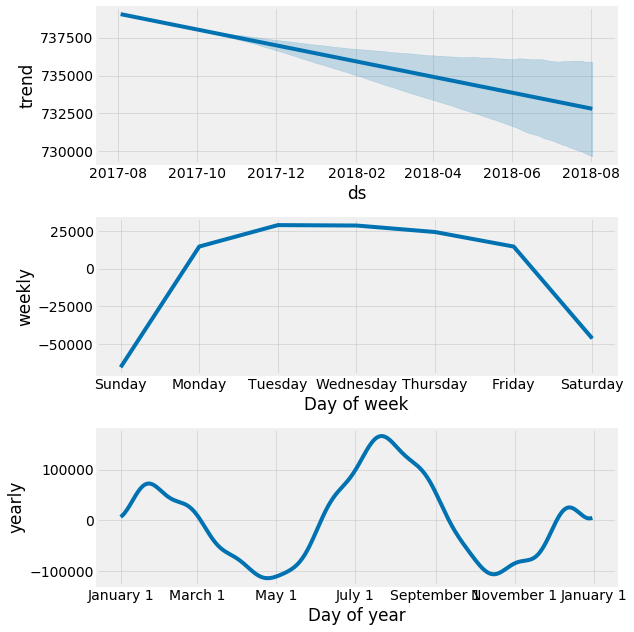

In [102]:
# checking the components in the model
model.plot_components(forecast)

plt.show()

You can easily see seasonality and trends - there's a clear downward trend and seasonality every year (more electricity is used in winter and summer)

Now let's evaluate the residuals and see whether the model is biased in any way. First we'll look at the distribution of the errors:



In [103]:
# First construct the residuals - basically the errors
prophet_errors = PROPHET_prediction.copy()
prophet_errors['PJME_MW_ACTUAL'] = test['PJME_MW']
prophet_errors['error'] = prophet_errors['PJME_MW'] - prophet_errors['PJME_MW_ACTUAL']

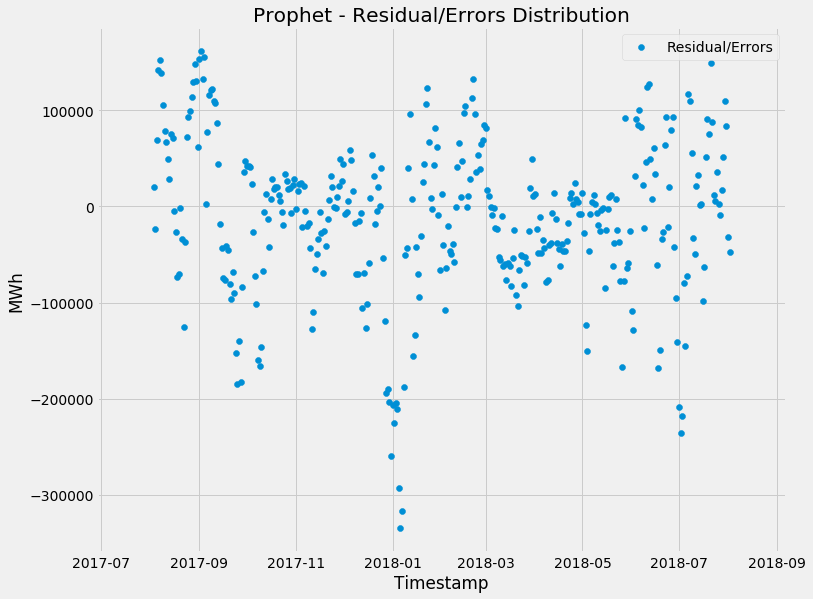

In [104]:
# Let's visually see the errors via scatterplot
plt.scatter(prophet_errors.index, prophet_errors['error'], label='Residual/Errors')

# Plot Labels, Legends etc
plt.title('Prophet - Residual/Errors Distribution')
plt.xlabel("Timestamp")
plt.ylabel("MWh")
plt.legend(loc='best')

plt.show()

Text(0.5, 1.0, 'Prophet - Residual/Errors Distribution')

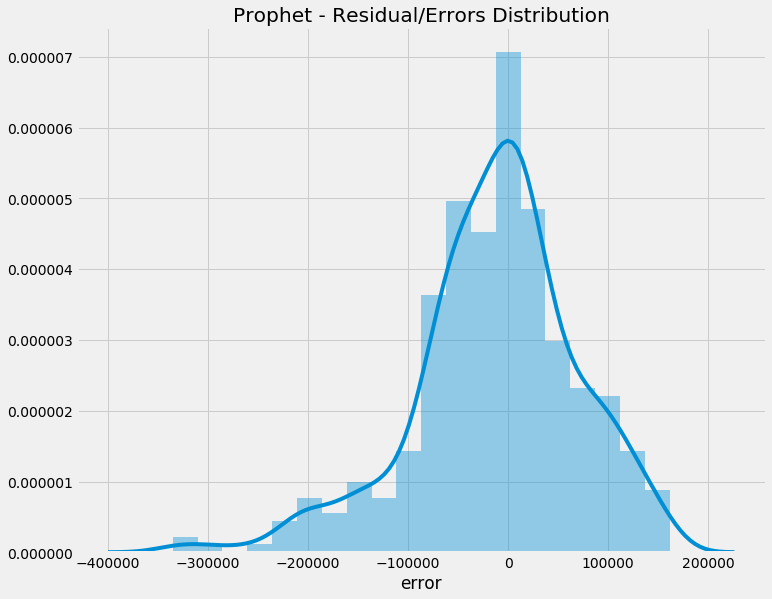

In [105]:
# Plot Histogram with Kernel Density Estimation (KDE)
sns.distplot(prophet_errors['error'], kde=True);

# Plot Labels, Legends etc
plt.title('Prophet - Residual/Errors Distribution')

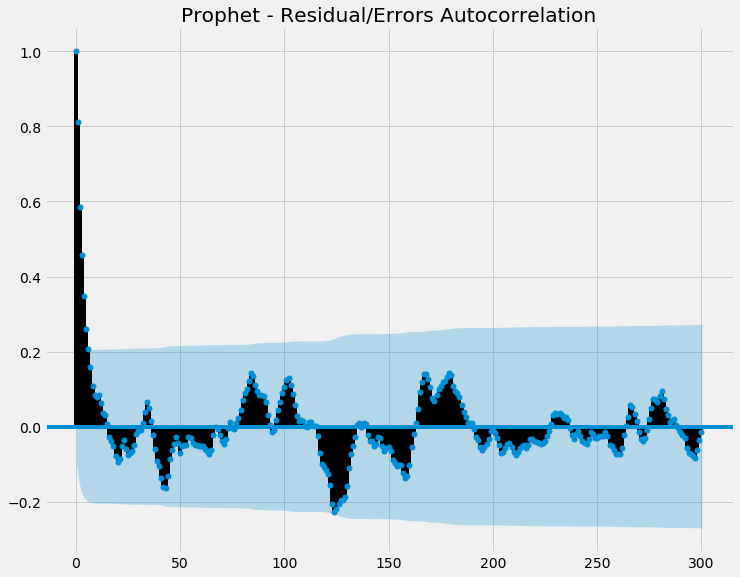

In [106]:
from statsmodels.graphics.tsaplots import plot_acf

# Plot the acf function
plot_acf(prophet_errors['error'],lags=300) #alpha 1 suppresses CI

plt.title('Prophet - Residual/Errors Autocorrelation')
plt.show()

Again, you can see that the errors seem to be distributed around zero and there's no statistically significant autocorrelation going on. This indicates that the model isn't biased and not leaning torwards under or over forecasting.

However, you can see that the model does seem to miss under forecast a bit more, particularly for spikes.

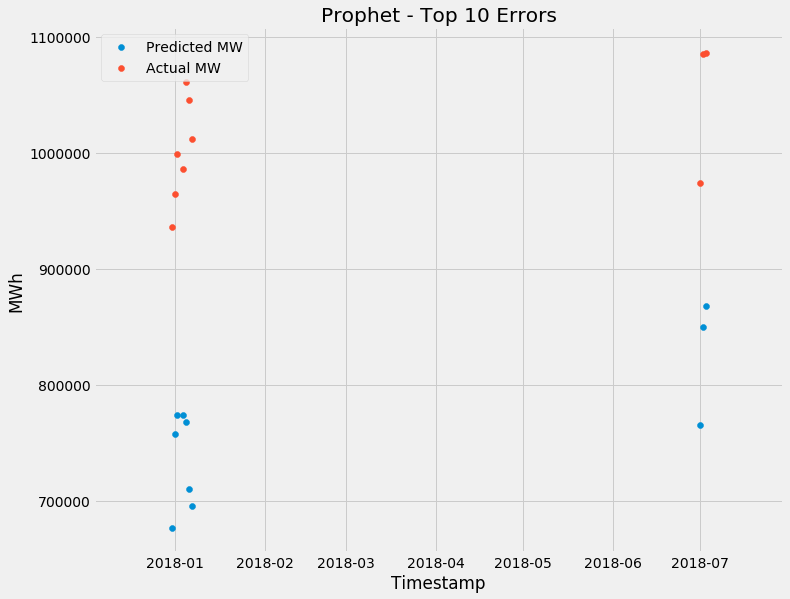

In [107]:
# Let's get the top 10 over forecasts 
#(i.e. where the error is the highest negative number)
top_10_errors = prophet_errors.sort_values('error', ascending=True)[['PJME_MW_ACTUAL', 'PJME_MW', 'error']].head(10)

plt.scatter(top_10_errors.index, top_10_errors['PJME_MW'], label='Predicted MW')
plt.scatter(top_10_errors.index, top_10_errors['PJME_MW_ACTUAL'], label='Actual MW')

# Labels, Titles, etc.
plt.title('Prophet - Top 10 Errors')
plt.xlabel("Timestamp")
plt.ylabel("MWh")
plt.legend(loc='best')

In [108]:
top_10_errors.head(10)

,PJME_MW_ACTUAL,PJME_MW,error
ds,,,
2018-01-06,1045578.0,710545.635028,-335032.364972
2018-01-07,1011833.0,695360.315691,-316472.684309
2018-01-05,1060747.0,767895.720925,-292851.279075
2017-12-31,936384.0,676343.951120,-260040.048880
2018-07-02,1085235.0,849650.204153,-235584.795847
2018-01-02,999056.0,773763.605279,-225292.394721
2018-07-03,1086193.0,868107.417636,-218085.582364
2018-01-04,985560.0,774322.297321,-211237.702679
2018-07-01,974036.0,765542.043107,-208493.956893


The most incorrect days were July and January, the peak of summer and winter respectively. Makes sense!

You get the biggest peaks in these periods due to weather.

## **Conclusion: - Bringing it all together**

Analyzing the results of the models.

In [90]:
print("MAE Baseline: {:.2f}".format(meanabs(test['PJME_MW'], baseline_prediction['PJME_MW'])))
print("MAE HoltWinters: {:.2f}".format(meanabs(test['PJME_MW'], HWES_prediction['PJME_MW'])))
print("MAE XGBoost: {:.2f}".format(mean_absolute_error(test_label, XGB_prediction_no_lag['PJME_MW'])))
print("MAE LASSO: {:.2f}".format(mean_absolute_error(test_label, LASSO_prediction['PJME_MW'])))
print("MAE SARIMA: {:.2f}".format(meanabs(test['PJME_MW'], SARIMA_prediction['PJME_MW'])))
#print("MAE Prophet: {:.2f}".format(meanabs(test['PJME_MW'], PROPHET_prediction['PJME_MW'])))

MAE Baseline: 87377.28
MAE HoltWinters: 156201.70
MAE XGBoost: 44861.71
MAE LASSO: 60568.64
MAE SARIMA: 133374.15


Now let's also look at Mean Absolute Percentage Error (MAPE)

Unlike MAE, MAPE has issues in its calculations, namely when the actual value is 0 (can't divide by zero) and negative values can't go beyond -100%.

Regardless, MAPE is a good 'sense-check' to see which model is proportionally better.

In [92]:
def MAPE(y_true, y_pred): 
    '''Function to calculate MAPE'''
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [109]:
print("MAE Baseline: {:.2f}%".format(MAPE(test['PJME_MW'], baseline_prediction['PJME_MW'])))
print("MAE HoltWinters: {:.2f}%".format(MAPE(test['PJME_MW'], HWES_prediction['PJME_MW'])))
print("MAE XGBoost: {:.2f}%".format(MAPE(test['PJME_MW'], XGB_prediction_no_lag['PJME_MW'])))
print("MAE LASSO: {:.2f}%".format(MAPE(test['PJME_MW'], LASSO_prediction['PJME_MW'])))
print("MAE SARIMA: {:.2f}%".format(MAPE(test['PJME_MW'], SARIMA_prediction['PJME_MW'])))
print("MAE Prophet: {:.2f}%".format(MAPE(test['PJME_MW'], PROPHET_prediction['PJME_MW'])))

MAE Baseline: 11.59%
MAE HoltWinters: 22.64%
MAE XGBoost: 5.97%
MAE LASSO: 7.91%
MAE SARIMA: 19.20%
MAE Prophet: 7.95%


XGBoost is the best performing model.

In [94]:
def plot_model_result(ax, prediction, model_name, color):
    '''
    Plot model results.
    
    prediction : DataFrame
    model_name : str
    
    return ax
    '''
    # Training and Test Actuals
    ax.scatter(x=train.index, y=train['PJME_MW'], label='Training Data', color='black')
    ax.scatter(x=test.index, y=test['PJME_MW'], label='Test Actuals', color='red')

    # Model Results
    ax.plot(prediction['PJME_MW'], label=model_name, color=color, alpha=0.7)
    
    # For clarify, let's limit to only August 2016 onwards
    ax.set_xlim(datetime(2016, 8, 1),datetime(2018, 10, 1))

    # Set Y Axis
    ax.set_ylim(500000, 1100000)
    
    # Set Axis labels
    ax.set_ylabel("MWh")
    ax.legend(loc='best')
    ax.set_title(
        "{}: MAPE: {:.2f}% | MAE: {:.2f}".format(
            model_name,MAPE(test["PJME_MW"], prediction["PJME_MW"]),
            mean_absolute_error(test["PJME_MW"], prediction["PJME_MW"])
            )
        , fontsize=40
    )

    return ax

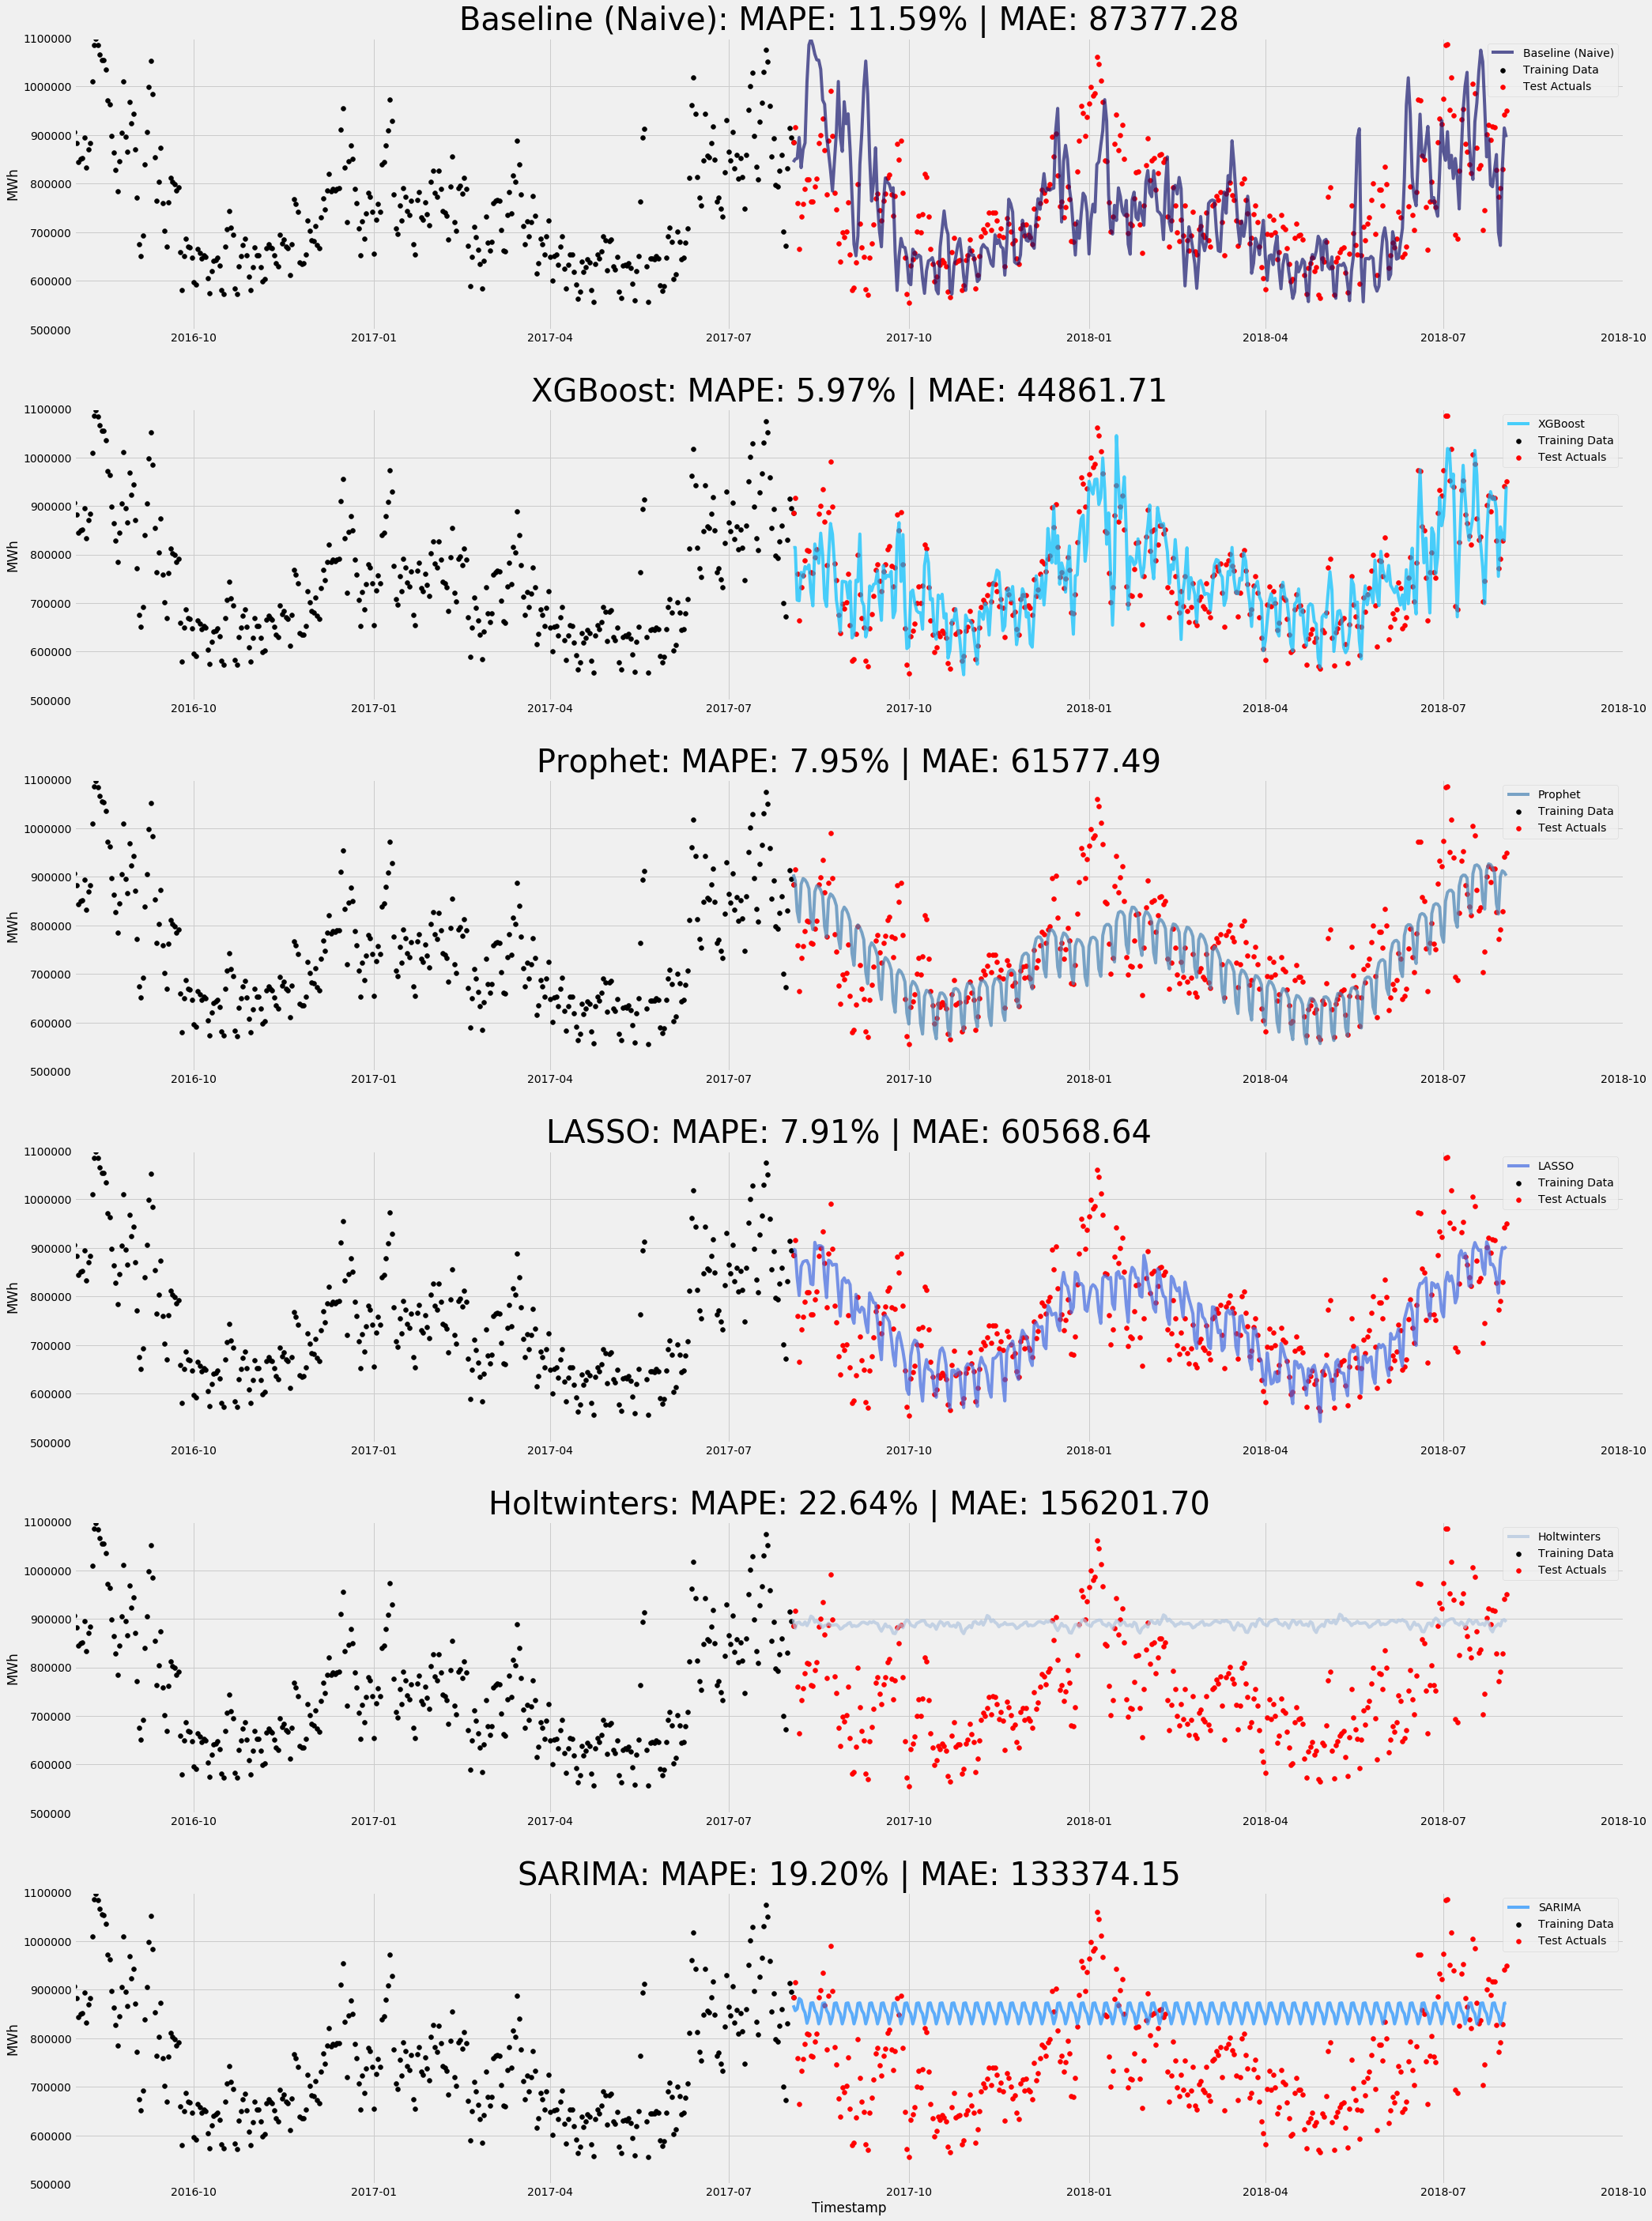

In [110]:
fig, ax = plt.subplots(6,1, figsize=(30,40))

# Plot Labels, Legends etc
plt.xlabel("Timestamp")

ax[0] = plot_model_result(ax[0], baseline_prediction, model_name='Baseline (Naive)', color='midnightblue')
ax[1] = plot_model_result(ax[1], XGB_prediction_no_lag, model_name='XGBoost', color='deepskyblue')
ax[2] = plot_model_result(ax[2], PROPHET_prediction, model_name='Prophet', color='steelblue')
ax[3] = plot_model_result(ax[3], LASSO_prediction, model_name='LASSO', color='royalblue')
ax[4] = plot_model_result(ax[4], HWES_prediction, model_name='Holtwinters', color='lightsteelblue')
ax[5] = plot_model_result(ax[5], SARIMA_prediction, model_name='SARIMA', color='dodgerblue')

plt.tight_layout(pad=3.0)
plt.show()

The lower the error the better/more accurate the model is, so therefore in this case, the winner is **XGBoost!** However, Prophet and Lasso still comes a pretty close second!

You can see that there was a lot of noise in this dataset and while there's high seasonality, more conventional statistical approaches, such as Holtwinters and SARIMA weren't able to get through all that noise.

Interestingly, all the forecasting models beat the baseline, except Holtwinters and SARIMA. This does at least demonstrate that we are still better off using these models than just doing naive forecasting.

Hopefully that gives you a bit of a flavour to time series forecasting and some of the unique aspects of it!

**Acknowledgements:**
Reference Notebook(Acknowlwdgemets): Albert Cheng, https://www.kaggle.com/alcheng10/forecasting-electricity-pjm-us-east-coast-grid/notebook